<a href="https://colab.research.google.com/github/gabrieladamasceno/PAIC/blob/master/Vers%C3%A3o_2_KFCM_W_2_ipynb_Usando_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U scikit-fuzzy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from google.colab import drive
import skfuzzy as fuzz
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.pyplot import figure
from decimal import Decimal, getcontext

In [ ]:
#drive.mount('/content/drive')

In [ ]:
#Renata
#data = pd.read_csv('/content/drive/My Drive/Dataset_AM_TRAB/multiple+features/mfeat-fac.csv', header=None,delim_whitespace=True)
#label= pd.read_csv('/content/drive/My Drive/Trabalho_ML/label.csv', header=None,delim_whitespace=True)

In [ ]:
#Gabi
#data = pd.read_csv('/content/drive/MyDrive/Datasets/mfeat-fac', header=None,delim_whitespace=True)
#label= pd.read_csv('/content/drive/MyDrive/Datasets/label.csv', header=None,delim_whitespace=True)

In [ ]:
#Dataset dos números

#X1=data.to_numpy()
#scaler = StandardScaler()
#X = scaler.fit_transform(X1)

In [ ]:
#Dataset iris

iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
target_df = pd.DataFrame(iris.target, columns=['target'])
data = np.array(iris_df)
X = data
label = np.array(iris.target)

#clusters = 3
#amostras = 150
#features = 4

In [ ]:
import numpy as np

class KFCM_K_W2:
    def __init__(self, data, c=3, m=1.6, max_iter=100, tol=1e-6):
        self.data = data
        self.c = c
        self.m = m
        self.n, self.p = data.shape
        self.U = np.zeros((self.c, self.n))
        self.g = np.zeros((self.c, self.p))
        self.s = np.ones((self.c, self.p))
        self.max_iter = max_iter
        self.tol = tol

#Testar colocando o módulo
    def gaussian_kernel(self, x, g, s):
          kernel = kernel = np.exp(-0.5 * (np.sum((x - g)**2 * s, axis=1)))
          #np.exp(-0.5 * np.sum([(x[:, j] - g[:, j])**2 * s[:, j]]))
          #print("Gaussian Kernel:", kernel)
          return kernel

        #print("x", x)
        #print("g", g)
        #print("s", s)
        #print("np.sum((x - g)**2 * s, axis=1)", np.sum((x - g)**2 * s, axis=1))


    def initialize(self):
        self.U = np.random.rand(self.c, self.n)
        #self.U /= self.U.sum(axis=0)
        self.U /= self.U.sum(axis=1)[:, np.newaxis]
        #self.g = self.data[[0,15,25],:]
        idx = np.random.choice(self.n, self.c, replace=False)
        self.g = self.data[idx]

        #printando a matriz U
        #print("Matriz U:",self.U)
        #print(self.U.shape)
        #print("Soma dos elementos da linha da matriz U", np.sum(self.U[0,:]))
        #print("Soma dos elementos da linha da matriz U", np.sum(self.U[1,:]))
        #print("Soma dos elementos da linha da matriz U", np.sum(self.U[2,:]))
        #print("Matriz G:",self.g)
        return self.U, self.g

#Eq.8
    def update_membership(self):
        epsilon = 1e-10
        for k in range(self.n):
            for i in range(self.c):
                kernel_values_i = self.gaussian_kernel(np.tile(self.data[k], (self.c, 1)), self.g[i], self.s[i])
                for h in range(self.c):
                  kernel_values_h = self.gaussian_kernel(np.tile(self.data[k], (self.c, 1)), self.g[h], self.s[i])

                sum_denominator = np.sum((2 - 2 * kernel_values_i) / ((2 - 2 * kernel_values_h) + epsilon))
                sum_denominator = sum_denominator ** (1 / (self.m - 1))
                self.U[i][k] = (1/sum_denominator)
                #if kernel_values_h[k]>=1:
                    #self.U[i][k] = 1

                #print("Update U", self.U)
        return self.U

#Eq.15b
    def compute_prototypes(self):
      numerator = np.zeros(self.p, dtype=np.float128)
      denominator = np.zeros(self.p, dtype=np.float128)

      for i in range(self.c):
        for k in range(self.n):
            value_UK  = ((self.U[i][k])**self.m)  * self.gaussian_kernel(self.data, self.g[i], self.s[i])
            numerator = np.sum(value_UK[:, None] * self.data, axis=0)
            denominator = np.sum(value_UK)
        self.g[i] = numerator/denominator
        #return self.g


#eq.14b
    getcontext().prec = 120
    def compute_widths(self):
        for i in range(self.c):
            # U*kernel
            #value_UK = np.multiply(self.U[:i], kernel_values[:i])
            value_UK = np.multiply((self.U[i])**self.m, self.gaussian_kernel(self.data, self.g[i], self.s[i]))
            for j in range(self.p):
                numerator = Decimal('1')
                expoente = Decimal(self.p)
                pexp = Decimal('1')/expoente
                for h in range(self.p):
                    #Subtracao numerador
                    numdiff = self.data[:,h] - self.g[i,h]
                    # (x-g)^2
                    numerator_aux = np.multiply(value_UK, np.multiply(numdiff,numdiff))
                    #print("numerador", numerator)
                    numerator_aux = np.sum(numerator_aux)
                    numerator_aux = Decimal(numerator_aux)
                    numerator = numerator*numerator_aux
                numerator = numerator**pexp
                numerator = float(numerator)
                #print("numerator", numerator)
                dendiff = self.data[:,j] - self.g[i,j]
                denominator = np.multiply(value_UK, np.multiply(dendiff,dendiff))
                denominator = np.sum(denominator)
                #print("denominator_sum", denominator)
                self.s[i, j] = numerator/denominator
        max_value = np.max(self.s)
        self.s = self.s / max_value
        #mean = np.mean(self.s)
        #std_dev = np.std(self.s)
        #self.s = (self.s - mean) / std_dev
        print("Update S", self.s)
        return self.s
#Eq.13
    def compute_JNew(self):
        J = 0
        for i in range(self.c):
            kernel_values = self.gaussian_kernel(self.data, self.g[i], self.s[i])
            J += np.sum((self.U[i]**self.m) * (2 - 2 * kernel_values))
        return J

    def fit(self):
        U, g = self.initialize() #inicializa os protótipos
        J_old = np.inf
        contador = 1
        for iter_count in range(self.max_iter):
            s = self.compute_widths() #s janela s
            g = self.compute_prototypes() #g computa os protótipos
            U = self.update_membership() #update dos parâmetros uik da matriz U (matriz de pertinência)
            J_new = self.compute_JNew() #update função de custo
            if abs(J_new - J_old) < self.tol:
                break
            J_old = J_new
            contador += 1
        return s, g, U, J_old

***********************
Épocas:  0
Update S [[0.12618547 0.5666484  0.15684306 0.37928983]
 [0.13687747 0.6289602  0.13065179 0.3781717 ]
 [0.18688382 0.11834118 0.19233214 1.        ]]
Update S [[0.14380878 0.68937807 0.10282358 0.62502633]
 [0.14257832 1.         0.10590648 0.42194697]
 [0.39436848 0.59591039 0.0668026  0.40584231]]
Update S [[0.14729425 0.83247058 0.05995073 0.392867  ]
 [0.12800982 1.         0.07772605 0.29025841]
 [0.27620701 0.7612052  0.0502403  0.27340475]]
Update S [[0.17817019 0.9642026  0.05724412 0.29150724]
 [0.17482022 1.         0.05916207 0.27717148]
 [0.24789824 0.83988805 0.05104866 0.26971456]]
Update S [[0.22892063 0.99602183 0.05918031 0.29585302]
 [0.22905752 1.         0.059075   0.29502493]
 [0.26082709 0.93026375 0.05602492 0.29367501]]
Update S [[0.25226852 0.99984721 0.05976177 0.30401932]
 [0.25250901 1.         0.05971077 0.30394276]
 [0.26682887 0.96900505 0.0583071  0.3039772 ]]
Update S [[0.26234595 1.         0.05998102 0.30823604]
 [0

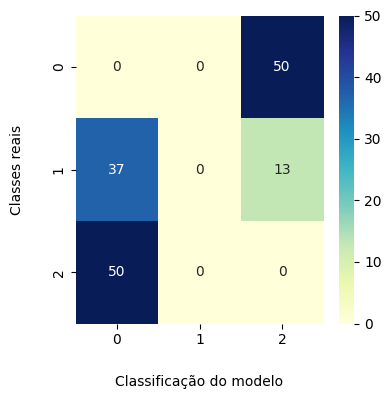

***********************
Épocas:  1
Update S [[0.52811438 0.21895037 0.1869886  1.        ]
 [0.36773465 0.97001838 0.12502903 0.48480095]
 [0.3986262  0.51140694 0.13729303 0.77251669]]
Update S [[0.44032796 0.28290561 0.06163645 0.48362327]
 [0.20693696 1.         0.06211791 0.2888735 ]
 [0.27752013 0.7572481  0.05715171 0.30917236]]
Update S [[0.38527533 0.55697794 0.05288303 0.31521525]
 [0.21843334 1.         0.05791515 0.28276238]
 [0.25695211 0.88257926 0.05484734 0.28758836]]
Update S [[0.32513805 0.79592946 0.05513197 0.30729571]
 [0.24658486 1.         0.05926701 0.30000123]
 [0.26461388 0.95406248 0.05768588 0.30105335]]
Update S [[0.29553936 0.91252804 0.05728189 0.30918054]
 [0.26007331 1.         0.05983596 0.30692548]
 [0.26827405 0.98082419 0.05907466 0.30726983]]
Update S [[0.28198191 0.96221893 0.05870395 0.31067527]
 [0.2659752  1.         0.06004958 0.3098261 ]
 [0.26971046 0.99155082 0.05969432 0.30997268]]
Update S [[0.2758414  0.98331532 0.05948173 0.31145295]
 [0

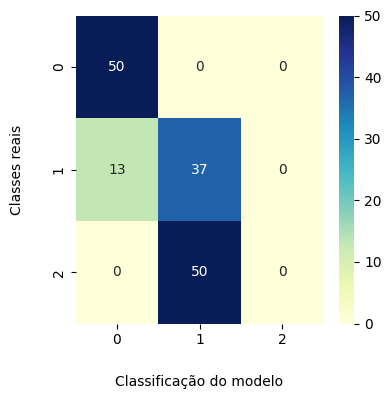

***********************
Épocas:  2
Update S [[0.11739955 0.73873803 0.0815898  1.        ]
 [0.21654088 0.59197761 0.13558255 0.40714001]
 [0.18208558 0.59642952 0.18314761 0.35575977]]
Update S [[0.19697195 1.         0.08091582 0.40691366]
 [0.25855193 0.76414277 0.07836829 0.41886822]
 [0.25990897 0.96840992 0.07330237 0.35151313]]
Update S [[0.2315299  1.         0.06276061 0.30166743]
 [0.27493544 0.86916645 0.0581976  0.31519835]
 [0.25235478 0.9615673  0.0594415  0.3039077 ]]
Update S [[0.25131052 1.         0.06000599 0.30411758]
 [0.27275587 0.94386251 0.05802338 0.30701594]
 [0.26060863 0.97857232 0.05896703 0.30496906]]
Update S [[0.26182913 1.         0.0600067  0.30838907]
 [0.27171392 0.97610442 0.05908805 0.30917821]
 [0.26615622 0.99003237 0.05956992 0.30867656]]
Update S [[0.26675115 1.         0.06010963 0.31049431]
 [0.27126588 0.9895331  0.05968395 0.31075699]
 [0.26874706 0.99547184 0.05991433 0.31059934]]
Update S [[0.26895137 1.         0.06016356 0.31142728]
 [0

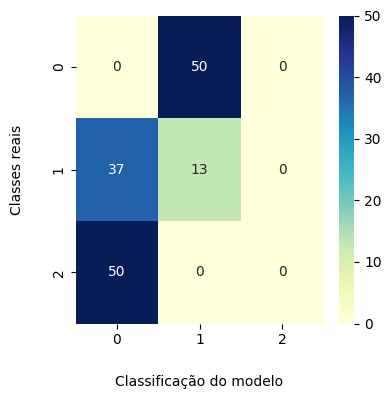

***********************
Épocas:  3
Update S [[0.26140593 0.67815857 0.20534758 0.51958033]
 [0.30226297 0.47022236 0.23852095 0.55792293]
 [0.2141232  1.         0.18947133 0.46621016]]
Update S [[0.2489637  0.89461173 0.09321999 0.33572789]
 [0.25511862 0.85529922 0.09357272 0.34139534]
 [0.26815266 1.         0.07306799 0.3557606 ]]
Update S [[0.24577266 1.         0.06430842 0.30901673]
 [0.2483114  0.99401416 0.06388795 0.30972424]
 [0.26257144 0.98335377 0.06068529 0.31170424]]
Update S [[0.2542643  1.         0.06040642 0.30611689]
 [0.25547799 0.99748203 0.06025678 0.30619017]
 [0.26342142 0.98196911 0.05927059 0.3066674 ]]
Update S [[0.26263691 1.         0.06009233 0.30886672]
 [0.2632023  0.99879923 0.06003106 0.30888871]
 [0.2670617  0.99046711 0.05962568 0.3090729 ]]
Update S [[0.26700514 1.         0.0601272  0.31060487]
 [0.26726672 0.99943184 0.06010056 0.31061489]
 [0.26906819 0.99545628 0.05992134 0.31069392]]
Update S [[0.26903888 1.         0.06016697 0.31145318]
 [0

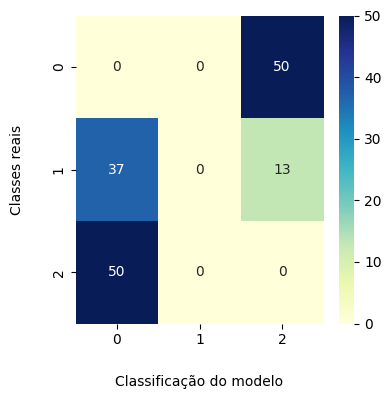

***********************
Épocas:  4
Update S [[0.14186639 0.17137249 0.21668578 1.        ]
 [0.14565316 0.54638305 0.14954531 0.44265065]
 [0.13475281 0.69851089 0.12349567 0.45319835]]
Update S [[0.39944636 0.23354765 0.0719853  0.75245142]
 [0.17669273 0.70464042 0.10217299 0.39722257]
 [0.23243599 1.         0.06665625 0.32614595]]
Update S [[0.47910207 0.4496511  0.05635603 0.38420767]
 [0.26830045 0.87424959 0.06099852 0.32601233]
 [0.25294434 1.         0.06001821 0.30725726]]
Update S [[0.40093424 0.67079629 0.0558063  0.32590856]
 [0.27386827 0.96006505 0.05944282 0.31296881]
 [0.26337041 1.         0.05997881 0.3096549 ]]
Update S [[0.33227049 0.8363583  0.0568458  0.31713736]
 [0.27245934 0.98608526 0.05978077 0.31192645]
 [0.26770646 1.         0.06013284 0.31121414]]
Update S [[0.29796722 0.92835079 0.05817951 0.3142133 ]
 [0.27157142 0.99461257 0.0600054  0.31199445]
 [0.26946351 1.         0.06018532 0.31180614]]
Update S [[0.28287654 0.96933612 0.05915378 0.31289122]
 [0

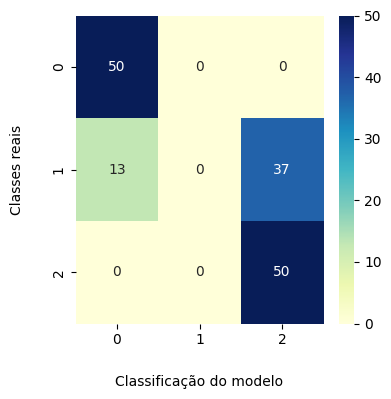

***********************
Épocas:  5
Update S [[0.0572412  0.08136778 0.05316325 1.        ]
 [0.10665368 0.20004865 0.07841007 0.14800943]
 [0.12020396 0.14204465 0.05407811 0.26816835]]
Update S [[0.41241295 0.35838388 0.06014246 0.66048767]
 [0.28381485 0.98924979 0.06272869 0.33336452]
 [0.27734497 1.         0.06347836 0.33348834]]
Update S [[0.4332645  0.57986811 0.05668688 0.35465049]
 [0.26971629 0.99298099 0.06024826 0.31302054]
 [0.26536484 1.         0.06083791 0.31285836]]
Update S [[0.36035225 0.7719936  0.05632378 0.32048314]
 [0.26967085 0.99577532 0.06000756 0.31162806]
 [0.26746757 1.         0.0602593  0.31156074]]
Update S [[0.31151737 0.89400939 0.05753211 0.31536049]
 [0.27023897 0.99780514 0.06009307 0.31183426]
 [0.26918949 1.         0.06020224 0.31179648]]
Update S [[0.28886695 0.95403341 0.05873228 0.31336351]
 [0.27052527 0.99893796 0.06015376 0.31201653]
 [0.27003623 1.         0.06020244 0.31199712]]
Update S [[0.27887927 0.98003592 0.0594704  0.31259984]
 [0

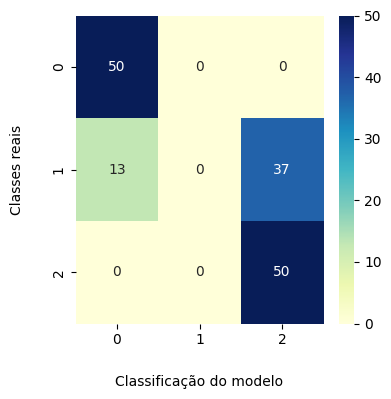

***********************
Épocas:  6
Update S [[0.1819833  0.13959226 0.29430055 0.56112267]
 [0.31589922 0.34326826 0.17186651 0.22509627]
 [0.1473771  0.14529371 0.19591375 1.        ]]
Update S [[0.62701413 0.82395726 0.12600261 0.72695247]
 [0.4861415  0.58542312 0.44059229 0.37739673]
 [0.64375283 1.         0.11001939 0.66815807]]
Update S [[0.47975646 0.90154577 0.07833964 0.44721329]
 [0.48632439 0.44809795 0.43640925 0.15933528]
 [0.46886746 1.         0.07567578 0.42706885]]
Update S [[0.35031671 0.95517488 0.06322054 0.34249771]
 [0.50524104 0.44007908 0.3857625  0.08447151]
 [0.33857484 1.         0.06319014 0.33865351]]
Update S [[0.29998733 0.98038762 0.06015963 0.31861223]
 [0.44050396 0.72396763 0.37977524 0.04654497]
 [0.29268072 1.         0.06056696 0.31800828]]
Update S [[0.21214054 0.74357971 0.04496079 0.23567603]
 [0.34194952 1.         0.20600235 0.02372829]
 [0.20925505 0.75024649 0.04519142 0.23559425]]
Update S [[0.27710823 0.99679868 0.06002996 0.31530757]
 [0

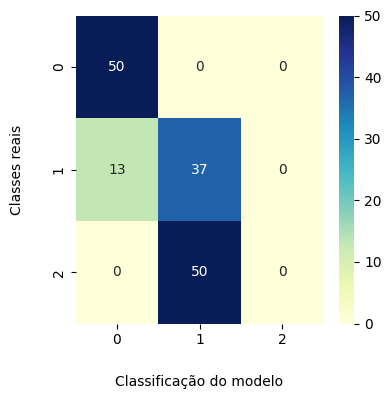

***********************
Épocas:  7
Update S [[0.13538226 1.         0.20478471 0.22889222]
 [0.22016486 0.51778317 0.17445493 0.31908848]
 [0.32782654 0.28179816 0.24289705 0.28280415]]
Update S [[0.03916981 1.         0.06795638 0.10224999]
 [0.04120902 0.22778874 0.14085565 0.20584776]
 [0.17756619 0.3216586  0.02909867 0.16376319]]
Update S [[0.10799503 1.         0.0553963  0.18713853]
 [0.073845   0.63513591 0.10273942 0.23233942]
 [0.19525936 0.6554128  0.04054162 0.2157843 ]]
Update S [[0.21889017 1.         0.05763775 0.28802355]
 [0.19337656 0.96110148 0.06426765 0.3042256 ]
 [0.25460416 0.90580275 0.05468182 0.28815039]]
Update S [[0.25071475 0.99823432 0.05934166 0.30242413]
 [0.24392295 1.         0.06041053 0.30480578]
 [0.26589341 0.96319634 0.05796191 0.30256828]]
Update S [[0.26132749 0.99610403 0.05968896 0.30688443]
 [0.25855931 1.         0.06004016 0.30715431]
 [0.26813897 0.98097245 0.0590384  0.30704876]]
Update S [[0.26638037 0.99759873 0.05993623 0.30958668]
 [0

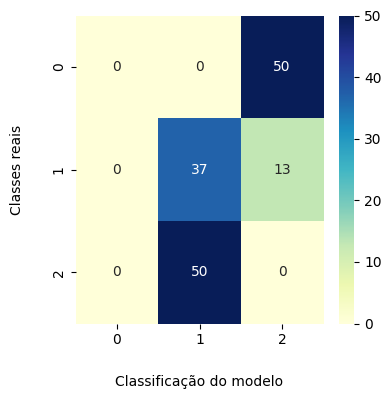

***********************
Épocas:  8
Update S [[0.17482501 0.65932029 0.16107227 0.40489216]
 [0.22663777 0.18078149 0.18347374 1.        ]
 [0.17757308 0.26151616 0.1955644  0.82774137]]
Update S [[0.08347911 0.69535388 0.18714415 1.        ]
 [0.42959959 0.63695978 0.08150559 0.48707596]
 [0.43763968 0.75817419 0.07427968 0.44076209]]
Update S [[0.01005697 1.         0.27771731 0.68979849]
 [0.2587359  0.64496918 0.04579586 0.25209873]
 [0.25061748 0.68853506 0.04531685 0.24637427]]
Update S [[0.00329427 1.         0.01838722 0.09292728]
 [0.05295092 0.17353781 0.01072791 0.05709993]
 [0.05184081 0.17709834 0.01077331 0.05690927]]
Update S [[0.17075239 1.         0.05481468 0.29413829]
 [0.23466226 0.84080324 0.05111998 0.27295244]
 [0.23411598 0.84230904 0.05115613 0.27290725]]
Update S [[0.24898095 1.         0.0590607  0.30423071]
 [0.26559722 0.96105814 0.0578734  0.30284162]
 [0.26531481 0.96171515 0.05789744 0.30283105]]
Update S [[0.26334782 1.         0.05990219 0.30864899]
 [0

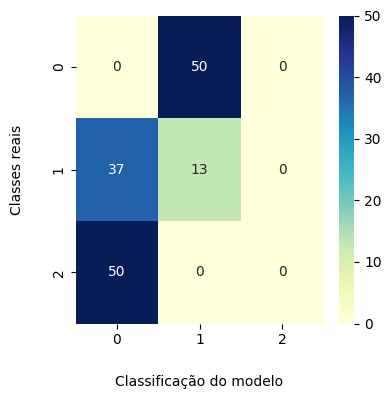

***********************
Épocas:  9
Update S [[0.20004215 0.58562678 0.13493705 0.48741129]
 [0.15133483 0.92545137 0.19210474 0.28637734]
 [0.16843664 0.24732538 0.1849541  1.        ]]
Update S [[0.0640554  0.34436427 0.06272585 0.28551366]
 [0.04395988 1.         0.07655699 0.11738319]
 [0.19217578 0.31753386 0.03275905 0.19761836]]
Update S [[0.12021053 0.63989173 0.04768359 0.26405878]
 [0.09648971 1.         0.06000301 0.16728791]
 [0.19037986 0.62645292 0.03900159 0.20822209]]
Update S [[0.22488193 0.93243425 0.0567663  0.2913116 ]
 [0.21160461 1.         0.05760887 0.28445047]
 [0.25212629 0.89385671 0.05400538 0.2849037 ]]
Update S [[0.2536798  0.98323651 0.0590151  0.30246905]
 [0.24841966 1.         0.05937412 0.3018595 ]
 [0.2656337  0.96048487 0.05779798 0.30192678]]
Update S [[0.26335012 0.99432735 0.0597046  0.30767897]
 [0.26114419 1.         0.05989338 0.30754548]
 [0.26889819 0.98284908 0.05914962 0.30771019]]
Update S [[0.26740335 0.99771089 0.05997905 0.31009006]
 [0

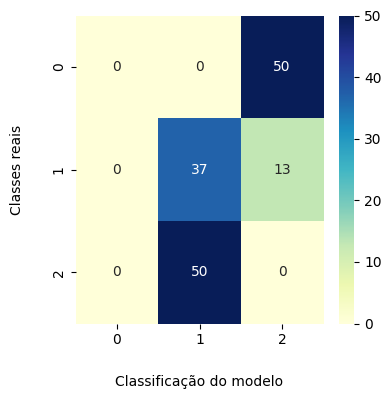

***********************
Épocas:  10
Update S [[0.15039105 0.42231098 0.08874883 0.31234078]
 [0.06175763 0.14394024 0.19804909 1.        ]
 [0.20035867 0.24632633 0.11130389 0.32049139]]
Update S [[0.32814934 0.89879724 0.06732778 0.37292455]
 [0.38851354 0.25498474 0.08722466 0.85701596]
 [0.29576939 1.         0.06993876 0.35799535]]
Update S [[0.28849993 0.94411479 0.06046859 0.32163176]
 [0.47875085 0.4628419  0.05852676 0.40847225]
 [0.27004071 1.         0.06181028 0.31737255]]
Update S [[0.27720093 0.97693433 0.05973187 0.31348817]
 [0.40252577 0.68364581 0.05610832 0.32842423]
 [0.26862377 1.         0.06042596 0.31240597]]
Update S [[0.27337619 0.99045699 0.0598929  0.31228659]
 [0.3334612  0.84194563 0.05689283 0.31705753]
 [0.26950885 1.         0.0602328  0.31197436]]
Update S [[0.27188882 0.9958934  0.06004736 0.31214606]
 [0.29869385 0.92960081 0.05817637 0.31418587]
 [0.27013893 1.         0.06020841 0.31204098]]
Update S [[0.27124582 0.99817928 0.0601317  0.31214774]
 [

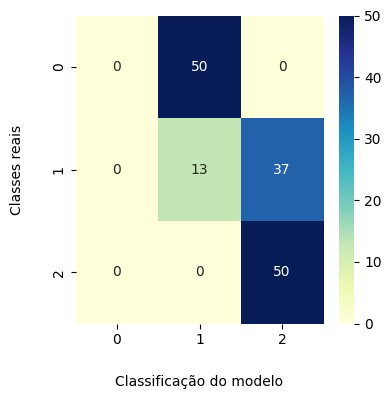

***********************
Épocas:  11
Update S [[0.2017677  0.16760959 0.2239771  0.99121579]
 [0.17238024 0.20392181 0.21358521 1.        ]
 [0.36943893 0.40314999 0.09080497 0.55514111]]
Update S [[0.44997492 0.2874138  0.09449029 0.7920737 ]
 [0.41912581 0.33691257 0.08934261 0.76723502]
 [0.35334512 1.         0.07140951 0.3836132 ]]
Update S [[0.47715252 0.50402591 0.06077386 0.40016364]
 [0.45727944 0.54522255 0.06010214 0.39031849]
 [0.29160062 1.         0.06201902 0.32340831]]
Update S [[0.38664801 0.73018557 0.05692206 0.3280217 ]
 [0.37705287 0.75632278 0.05676814 0.32562525]
 [0.27683179 1.         0.06052736 0.31460415]]
Update S [[0.32435901 0.87255955 0.05741932 0.3166201 ]
 [0.32046383 0.88445949 0.05745767 0.3159458 ]
 [0.27286767 1.         0.06027054 0.31286748]]
Update S [[0.2947823  0.94372958 0.05850792 0.3138937 ]
 [0.29317259 0.94841257 0.05857736 0.31368649]
 [0.27155213 1.         0.06022298 0.31241419]]
Update S [[0.28151159 0.97538174 0.05932661 0.31285231]
 [

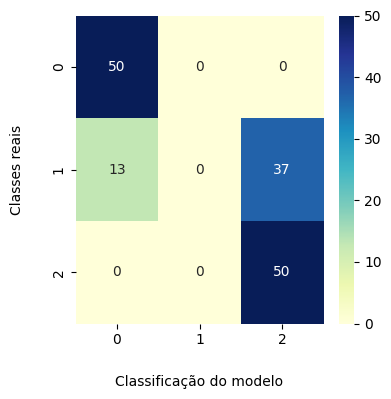

***********************
Épocas:  12
Update S [[0.20189805 1.         0.20905859 0.62230232]
 [0.30490695 0.65370635 0.30081799 0.43807425]
 [0.28501423 0.21111788 0.48091944 0.90769024]]
Update S [[0.04337221 0.49203129 0.29111521 1.        ]
 [0.30709563 0.55534663 0.23364445 0.15591071]
 [0.38180916 0.34665749 0.08857897 0.52989722]]
Update S [[0.03394671 1.         0.11362596 0.66002103]
 [0.12656351 0.6233439  0.17688469 0.18243435]
 [0.28513476 0.66247876 0.04901857 0.27494786]]
Update S [[0.10273282 1.         0.0928513  0.58324319]
 [0.1824102  0.94893395 0.090875   0.35368557]
 [0.29837221 0.97545102 0.05997832 0.31870488]]
Update S [[0.16559399 1.         0.06408324 0.33671313]
 [0.19932533 0.98665564 0.06223929 0.29191496]
 [0.25642029 0.90176391 0.0543182  0.2844844 ]]
Update S [[0.22542792 1.         0.06032418 0.30017929]
 [0.23411101 0.9907947  0.0594275  0.29613302]
 [0.26010907 0.9398393  0.05654879 0.29528909]]
Update S [[0.25108273 1.         0.05993135 0.30428254]
 [

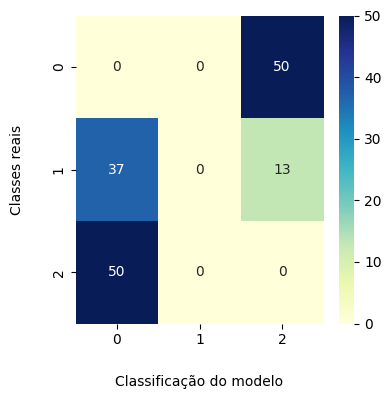

***********************
Épocas:  13
Update S [[0.17316697 0.41590715 0.0919317  1.        ]
 [0.10534387 0.68038637 0.12262761 0.75330974]
 [0.16070544 0.24307663 0.19455212 0.87119818]]
Update S [[0.1918925  0.36978858 0.03567389 1.        ]
 [0.07286615 0.4892069  0.17155703 0.41393775]
 [0.3037674  0.52130492 0.05177827 0.30873183]]
Update S [[0.2124659  0.56961391 0.09628975 0.60366695]
 [0.07134446 0.82434106 0.24106805 0.49618134]
 [0.32687929 1.         0.06331931 0.33987852]]
Update S [[0.25197487 0.72580426 0.07002092 0.43661256]
 [0.02032646 0.72364935 0.43816036 0.86751661]
 [0.29153796 1.         0.06040507 0.31749164]]
Update S [[0.23593728 1.         0.06422488 0.31599524]
 [0.06074995 0.70228545 0.24694792 0.45448074]
 [0.27225936 0.97636231 0.05877462 0.30647621]]
Update S [[0.19743688 0.80569164 0.04876612 0.24393417]
 [0.05512073 1.         0.10816933 0.31737222]
 [0.21335772 0.7778273  0.04681834 0.24354571]]
Update S [[0.24370667 0.93068782 0.05580443 0.28809447]
 [

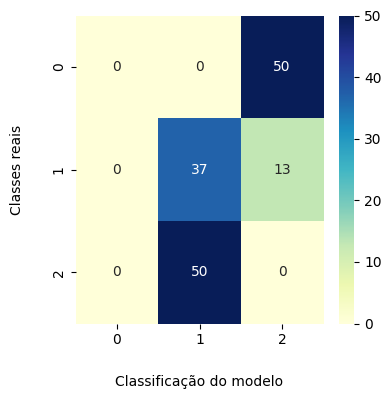

***********************
Épocas:  14
Update S [[0.07533907 0.03787141 0.28387388 1.        ]
 [0.10230952 0.52189476 0.09369213 0.16190306]
 [0.11715736 0.38446375 0.08363645 0.21499909]]
Update S [[0.32189657 0.02368866 0.16416842 1.        ]
 [0.17939365 0.70439625 0.04446276 0.22280555]
 [0.19014277 0.67344534 0.04328478 0.22585469]]
Update S [[0.54842617 0.23257448 0.0715086  0.54932839]
 [0.26645823 1.         0.06012799 0.3127265 ]
 [0.27128456 0.9879273  0.05971518 0.31306585]]
Update S [[0.4728002  0.50932131 0.05841108 0.35686963]
 [0.26813919 1.         0.06018022 0.31107149]
 [0.2703386  0.99488785 0.05997507 0.31118694]]
Update S [[0.36675215 0.74595148 0.05705188 0.32366093]
 [0.26943972 1.         0.06017648 0.31156962]
 [0.27044294 0.99772663 0.06008106 0.31161524]]
Update S [[0.31258966 0.88822193 0.05779346 0.3160035 ]
 [0.27011271 1.         0.06019068 0.31188353]
 [0.27057147 0.99897038 0.06014672 0.31190341]]
Update S [[0.28904783 0.953297   0.05880803 0.31348788]
 [

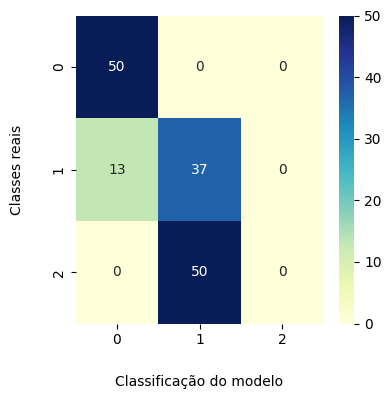

***********************
Épocas:  15
Update S [[0.17191287 0.13836697 0.22332736 1.        ]
 [0.10053942 0.70992673 0.07621856 0.97649966]
 [0.18559789 0.20864394 0.16581707 0.82732225]]
Update S [[0.39802319 0.46538512 0.09404417 0.55393238]
 [0.08773086 0.78790175 0.13959988 1.        ]
 [0.41849508 0.76162088 0.07143047 0.42383496]]
Update S [[0.38816523 0.83395726 0.06693761 0.37596821]
 [0.13512173 0.84603778 0.14806108 0.48131109]
 [0.35601714 1.         0.06493006 0.35242361]]
Update S [[0.32136441 0.93231784 0.06004761 0.32416488]
 [0.08233525 0.52612431 0.16541171 0.81392249]
 [0.30004413 1.         0.06069271 0.32025933]]
Update S [[0.2929849  0.97129911 0.0594608  0.31516752]
 [0.1274204  0.89517766 0.09461889 0.49413363]
 [0.28158212 1.         0.06021774 0.3145147 ]]
Update S [[0.26864696 0.94480415 0.05717603 0.29987303]
 [0.2063988  1.         0.0655101  0.32185457]
 [0.26335973 0.95701268 0.05761598 0.29968506]]
Update S [[0.26562382 0.95893019 0.0578154  0.30185117]
 [

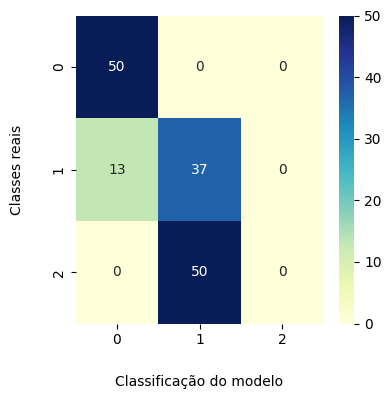

***********************
Épocas:  16
Update S [[0.17624976 1.         0.18299157 0.34138727]
 [0.21989228 0.66809699 0.18356575 0.40828724]
 [0.18018096 0.71055732 0.19988444 0.43024907]]
Update S [[0.2675839  1.         0.07422063 0.37056495]
 [0.27078861 0.98018478 0.07627189 0.36353488]
 [0.2628979  0.99092233 0.07699889 0.36689158]]
Update S [[0.267268   0.98757824 0.06147747 0.31836335]
 [0.26375061 0.99434622 0.06208762 0.31726445]
 [0.262435   1.         0.06209286 0.31702542]]
Update S [[0.26846382 0.99328572 0.060111   0.31195766]
 [0.26622986 0.99824151 0.06036048 0.31171989]
 [0.26584147 1.         0.06036648 0.31159538]]
Update S [[0.26963993 0.996994   0.06008836 0.31173035]
 [0.26854378 0.99946787 0.06019838 0.31165741]
 [0.26839718 1.         0.06020545 0.31162506]]
Update S [[0.2702548  0.99866989 0.06014551 0.31194067]
 [0.26974387 0.99982138 0.06019524 0.31191364]
 [0.2696833  1.         0.06019957 0.31190556]]
Update S [[0.27052139 0.99940425 0.06017894 0.31206737]
 [

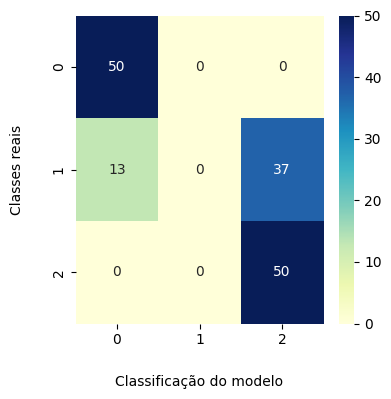

***********************
Épocas:  17
Update S [[0.20619277 0.15024505 0.18580022 0.69261297]
 [0.07723184 0.20670849 0.24972138 1.        ]
 [0.11929259 0.59717455 0.17773386 0.3148658 ]]
Update S [[0.46817352 0.29828887 0.07809925 0.60660412]
 [0.31842043 0.30907857 0.09630824 0.69801191]
 [0.26087471 1.         0.07196661 0.3523977 ]]
Update S [[0.47793055 0.51003099 0.05716272 0.36253711]
 [0.44123044 0.51488831 0.05770712 0.38531755]
 [0.26169147 1.         0.06140916 0.31434317]]
Update S [[0.38639629 0.71404114 0.05600332 0.32298709]
 [0.38990629 0.71643492 0.0553413  0.32282621]
 [0.2659552  1.         0.06027773 0.31130766]]
Update S [[0.32375122 0.86114505 0.05710405 0.3163915 ]
 [0.32958222 0.8548662  0.05665165 0.31557675]
 [0.2685342  1.         0.06019437 0.31161906]]
Update S [[0.29417183 0.93944109 0.05840045 0.31384433]
 [0.29737382 0.9336425  0.05813887 0.31379873]
 [0.26975733 1.         0.06019851 0.31191922]]
Update S [[0.28121158 0.97391493 0.05928318 0.31276395]
 [

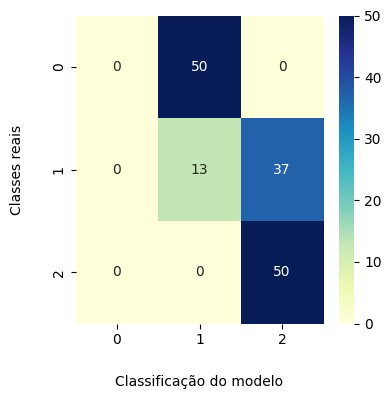

***********************
Épocas:  18
Update S [[0.26564875 0.52551845 0.18309314 0.38505806]
 [0.36817549 0.23966448 0.19106463 0.58378807]
 [0.14026929 0.34609178 0.20274034 1.        ]]
Update S [[0.20488261 0.80785607 0.17995036 0.17656309]
 [0.12174462 0.38014933 0.11362861 1.        ]
 [0.36577836 0.59986805 0.06298354 0.38053172]]
Update S [[0.23570014 0.71932021 0.09872958 0.47403788]
 [0.20483164 0.84585868 0.07983268 0.57367625]
 [0.34868198 1.         0.06483293 0.3510082 ]]
Update S [[0.21308247 0.94021294 0.0631869  0.3335432 ]
 [0.20087121 1.         0.06043795 0.34779687]
 [0.27565428 0.92446582 0.05605632 0.29557857]]
Update S [[0.22323471 0.99231868 0.06005781 0.29407897]
 [0.22118939 1.         0.0598758  0.29541377]
 [0.26000307 0.9257162  0.05574721 0.29158615]]
Update S [[0.24694706 0.9991729  0.05983984 0.30198733]
 [0.24681448 1.         0.05980903 0.30205516]
 [0.26504733 0.9623133  0.05790447 0.30190593]]
Update S [[0.2596843  0.9999826  0.05996211 0.30718259]
 [

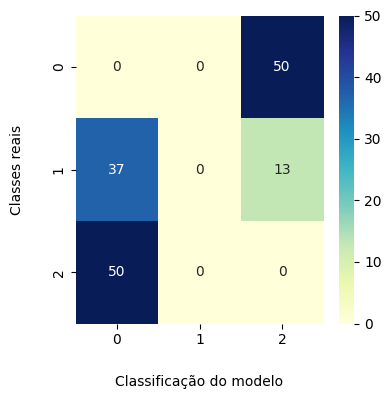

***********************
Épocas:  19
Update S [[0.17758308 0.29026445 0.07889572 0.24448415]
 [0.09985391 0.12364917 0.12861739 0.6260999 ]
 [0.06347545 0.07392937 0.21187356 1.        ]]
Update S [[0.32529453 0.72824555 0.09886254 0.82559612]
 [0.49870775 1.         0.0806134  0.48095078]
 [0.50605791 0.79516438 0.0887762  0.541253  ]]
Update S [[0.1718227  0.76444293 0.08735674 0.65036895]
 [0.35562922 1.         0.06176242 0.33975047]
 [0.37079415 0.90448245 0.0633545  0.35121358]]
Update S [[0.17088515 0.99587658 0.07278665 0.41959087]
 [0.2832393  1.         0.05923034 0.30980605]
 [0.29821856 0.95361501 0.05866684 0.31152089]]
Update S [[0.21143161 1.         0.06105059 0.30587638]
 [0.2541263  0.94456511 0.05641964 0.29153717]
 [0.26337604 0.92318393 0.05567222 0.29167737]]
Update S [[0.24396955 1.         0.0598983  0.30226638]
 [0.26081571 0.96846323 0.05810059 0.30098339]
 [0.26540416 0.95844092 0.05768275 0.30103776]]
Update S [[0.25855413 1.         0.0599485  0.30679296]
 [

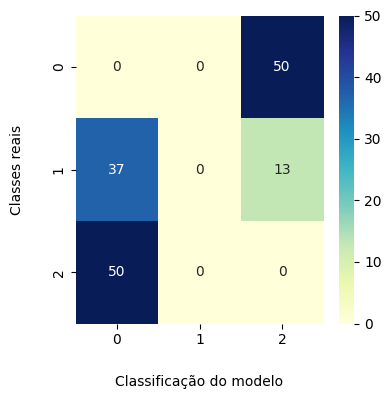

***********************
Épocas:  20
Update S [[0.15789835 0.41912071 0.08313168 0.22675591]
 [0.18591761 0.24482623 0.10356729 0.26463106]
 [0.10102778 0.15321032 0.08059592 1.        ]]
Update S [[0.24266166 1.         0.07363075 0.32554735]
 [0.24610301 0.86681461 0.08029002 0.33960169]
 [0.22632015 0.96784544 0.07438944 0.35697193]]
Update S [[0.26153591 0.96797101 0.05918156 0.31315572]
 [0.2623576  0.94044281 0.06007098 0.31655536]
 [0.2491564  1.         0.06086721 0.30937482]]
Update S [[0.26959454 0.98006367 0.05908355 0.31029794]
 [0.26925877 0.97607641 0.05929865 0.31082246]
 [0.26130141 1.         0.0599706  0.30912258]]
Update S [[0.27096569 0.99032589 0.05969882 0.31126401]
 [0.27061316 0.99022005 0.05976799 0.31134211]
 [0.26680774 1.         0.06010922 0.31091924]]
Update S [[0.27103766 0.99554677 0.05998901 0.31180724]
 [0.27083517 0.99582805 0.06001525 0.31181582]
 [0.26908951 1.         0.06017689 0.31168986]]
Update S [[0.27092285 0.99797057 0.060112   0.31202577]
 [

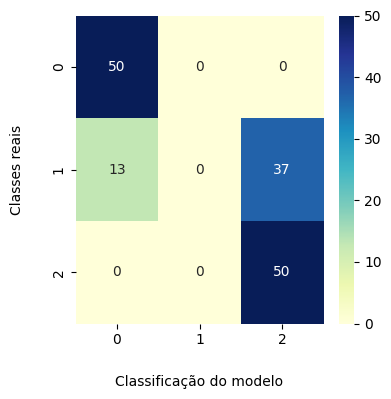

***********************
Épocas:  21
Update S [[0.3099912  0.16885918 0.20621837 0.52838809]
 [0.2194084  0.40194822 0.19272798 0.33557243]
 [0.26951024 0.09771019 0.21659045 1.        ]]
Update S [[0.30727886 0.88733609 0.39767273 0.60636123]
 [0.42584193 0.93411166 0.42321407 0.3905447 ]
 [0.72968732 1.         0.12180785 0.73971762]]
Update S [[0.26921588 1.         0.25433463 0.21728147]
 [0.39877272 0.69326022 0.35061582 0.15348843]
 [0.48577611 0.93072618 0.07589986 0.43354064]]
Update S [[0.08758234 1.         0.11853005 0.16199175]
 [0.28519622 0.59980144 0.22848043 0.04302666]
 [0.23897826 0.68071555 0.04382814 0.23586352]]
Update S [[0.14722973 1.         0.07070405 0.27986691]
 [0.14872788 0.58870073 0.12080203 0.27544201]
 [0.24542858 0.84786772 0.05152144 0.27173784]]
Update S [[0.2191083  1.         0.06012047 0.29501616]
 [0.20427911 0.93625367 0.0672019  0.30236251]
 [0.25798685 0.92568282 0.05575077 0.29188805]]
Update S [[0.24823064 0.99761236 0.05966953 0.30237845]
 [

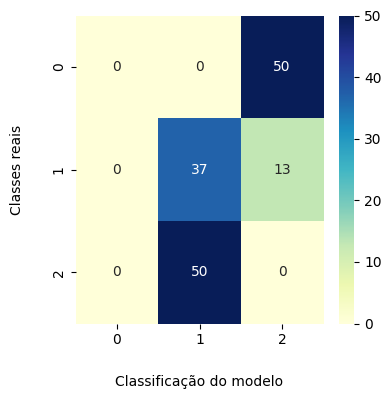

***********************
Épocas:  22
Update S [[0.17618642 0.39751079 0.10497782 0.17724127]
 [0.06899953 0.11443033 0.16504276 1.        ]
 [0.16220142 0.24128936 0.11393587 0.29223383]]
Update S [[0.33303948 0.87866927 0.06652679 0.36926458]
 [0.42579125 0.32756591 0.0787543  0.65446392]
 [0.29260935 1.         0.06917853 0.35513694]]
Update S [[0.2904691  0.93721597 0.06028902 0.32151641]
 [0.45330921 0.55356318 0.05782478 0.36366817]
 [0.26998605 1.         0.06166855 0.3169392 ]]
Update S [[0.2780646  0.97466718 0.05967763 0.31356625]
 [0.37191229 0.75176076 0.05628828 0.32225874]
 [0.26876415 1.         0.06040726 0.31237942]]
Update S [[0.27375895 0.98964556 0.0598695  0.31232976]
 [0.31707067 0.88202246 0.05736574 0.31577568]
 [0.26959409 1.         0.06023083 0.31198792]]
Update S [[0.272059   0.99557206 0.06003638 0.3121646 ]
 [0.29132003 0.94839643 0.058592   0.31357062]
 [0.27017923 1.         0.06020842 0.31205038]]
Update S [[0.27132183 0.9980427  0.06012653 0.31215549]
 [

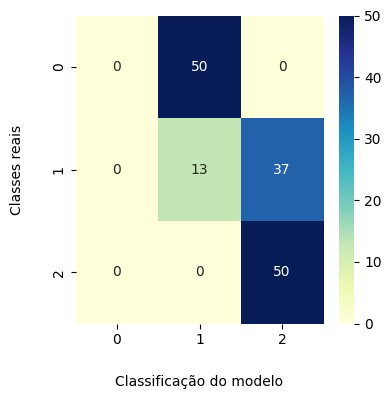

***********************
Épocas:  23
Update S [[0.2756948  0.53434074 0.11552971 0.37812719]
 [0.13995398 1.         0.10850962 0.42376487]
 [0.29878939 0.29924782 0.17365514 0.41447148]]
Update S [[0.19107676 0.76015242 0.10366267 0.4836676 ]
 [0.13098099 1.         0.17167702 0.32386014]
 [0.37970987 0.81207361 0.06489132 0.36395196]]
Update S [[0.17787175 1.         0.07689587 0.38827834]
 [0.08623194 0.7160252  0.21685687 0.39662813]
 [0.30607465 0.93827674 0.05881944 0.31439376]]
Update S [[0.20548906 1.         0.06076786 0.30056505]
 [0.0766238  0.56311863 0.11668791 0.7454383 ]
 [0.26222027 0.90705856 0.05482012 0.28784556]]
Update S [[0.24015041 1.         0.05973887 0.30037008]
 [0.16543109 0.90399268 0.07315071 0.39390949]
 [0.26455399 0.95105654 0.05725281 0.29914352]]
Update S [[0.25306363 0.98546774 0.05902072 0.3015159 ]
 [0.22880268 1.         0.06253569 0.31016861]
 [0.26397361 0.96251031 0.05792437 0.30155026]]
Update S [[0.2606129  0.98499472 0.05912385 0.30467839]
 [

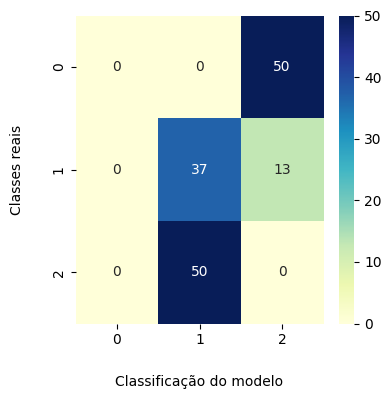

***********************
Épocas:  24
Update S [[0.19637575 0.12117094 0.15345556 0.75238592]
 [0.06543061 0.18108182 0.23187493 1.        ]
 [0.17683118 0.60799826 0.09029693 0.28299285]]
Update S [[0.45361521 0.25906159 0.07091549 0.61825342]
 [0.325101   0.26159158 0.08633114 0.70176016]
 [0.25683196 1.         0.06276772 0.31960449]]
Update S [[0.47537323 0.49498055 0.05708795 0.36363623]
 [0.44917111 0.49352525 0.05746462 0.38345352]
 [0.26122741 1.         0.06029727 0.31011164]]
Update S [[0.38426511 0.71239553 0.05620791 0.32374544]
 [0.38959247 0.70905654 0.05566186 0.32396948]
 [0.26637633 1.         0.06014493 0.31092711]]
Update S [[0.32246319 0.86317623 0.05722677 0.31653946]
 [0.32823621 0.85502263 0.05684347 0.31605455]
 [0.26884851 1.         0.06017916 0.31163984]]
Update S [[0.29355155 0.94099276 0.0584656  0.3138504 ]
 [0.29657045 0.93503972 0.0582342  0.31387575]
 [0.26991483 1.         0.06019752 0.31195248]]
Update S [[0.28092051 0.97471438 0.05931545 0.31276236]
 [

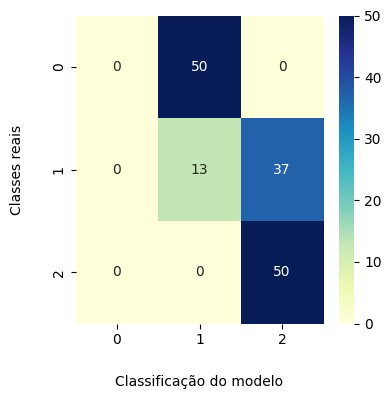

***********************
Épocas:  25
Update S [[0.10226745 0.12048115 0.22033532 1.        ]
 [0.26517571 0.3909781  0.10946193 0.23921663]
 [0.12022979 0.65065454 0.12125043 0.28621658]]
Update S [[0.3968446  0.18283866 0.09438826 0.83734654]
 [0.2699508  0.96554493 0.06768304 0.3250684 ]
 [0.2645751  1.         0.06524181 0.3322284 ]]
Update S [[0.49832219 0.4054556  0.05914883 0.418075  ]
 [0.26072224 1.         0.06145945 0.31180791]
 [0.26464403 0.99730179 0.06062752 0.3122449 ]]
Update S [[0.41347441 0.64372762 0.05616457 0.33063126]
 [0.26419055 1.         0.06030455 0.31023432]
 [0.26670405 0.99558352 0.05998538 0.31031617]]
Update S [[0.33786173 0.82240379 0.05678341 0.31736442]
 [0.26751425 1.         0.06017793 0.31104242]
 [0.26876249 0.99743929 0.06004393 0.31108534]]
Update S [[0.30038339 0.92185405 0.05804761 0.31414972]
 [0.26924692 1.         0.0601831  0.31162607]
 [0.26983415 0.99873233 0.060124   0.31164863]]
Update S [[0.28390882 0.96651882 0.05906463 0.31284753]
 [

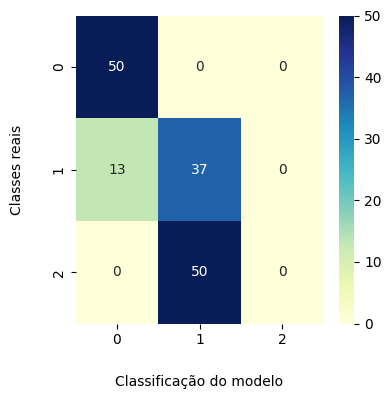

***********************
Épocas:  26
Update S [[0.10389845 0.78334326 0.06602971 0.43641861]
 [0.08054139 0.14853139 0.19604982 1.        ]
 [0.18843833 0.6994506  0.11626362 0.15305012]]
Update S [[0.23605604 1.         0.06054493 0.31300931]
 [0.36549622 0.27503186 0.07137904 0.62346716]
 [0.24229825 0.99171347 0.0610626  0.30488665]]
Update S [[0.25720319 0.9978416  0.05982403 0.30805768]
 [0.44249258 0.52301012 0.05674078 0.36019222]
 [0.25757095 1.         0.0597532  0.30731775]]
Update S [[0.26528674 0.9991337  0.06004983 0.31039439]
 [0.3736616  0.73402808 0.05599206 0.32169714]
 [0.26525974 1.         0.06002958 0.31026168]]
Update S [[0.26849468 0.99977798 0.0601599  0.31149766]
 [0.31855241 0.87370224 0.05721803 0.3158813 ]
 [0.26847913 1.         0.06015515 0.31147115]]
Update S [[0.2697839  0.99995094 0.06019335 0.31190871]
 [0.29200597 0.94513241 0.05851702 0.3136203 ]
 [0.26978019 1.         0.06019226 0.31190337]]
Update S [[0.27031261 0.99999019 0.06020327 0.3120643 ]
 [

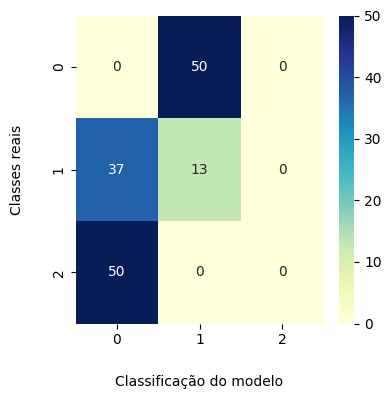

***********************
Épocas:  27
Update S [[0.45719882 0.39507214 0.40812141 0.39375121]
 [0.32317004 0.88154103 0.20641714 0.49359801]
 [0.29673907 1.         0.22699894 0.4309176 ]]
Update S [[0.4345542  0.42937449 0.08829299 0.47752166]
 [0.14638934 0.59623547 0.20040523 0.44974171]
 [0.23637423 1.         0.08834445 0.37672124]]
Update S [[0.45476088 0.57362671 0.05458774 0.34269808]
 [0.24262404 0.73043946 0.07373938 0.37342351]
 [0.24910693 1.         0.0623899  0.31399237]]
Update S [[0.3869784  0.73243444 0.05434593 0.31507498]
 [0.27427283 0.92112885 0.06026116 0.31878348]
 [0.26082443 1.         0.06011592 0.3095271 ]]
Update S [[0.32789771 0.8573686  0.05634108 0.3144688 ]
 [0.27287709 0.97642753 0.05980799 0.31256647]
 [0.2664911  1.         0.06012087 0.31088573]]
Update S [[0.29671876 0.93373827 0.05805606 0.3135671 ]
 [0.2716729  0.99200895 0.05997774 0.31202986]
 [0.26893579 1.         0.06017666 0.31165311]]
Update S [[0.28250561 0.97052765 0.05912564 0.31272702]
 [

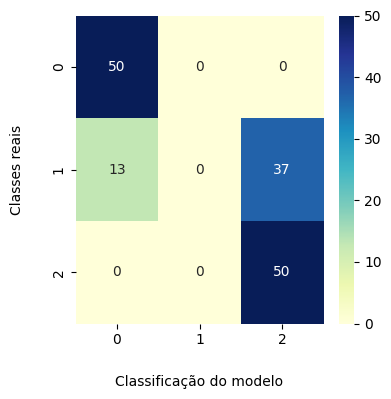

***********************
Épocas:  28
Update S [[0.13835676 0.15570778 0.18769479 1.        ]
 [0.17065883 0.52761557 0.13350901 0.33636127]
 [0.18220805 0.11497088 0.23202415 0.83190606]]
Update S [[0.53037256 0.83160989 0.09899419 0.59584358]
 [0.31574586 1.         0.11582244 0.71139748]
 [0.56683967 0.8438342  0.09518752 0.57140671]]
Update S [[0.41047956 0.94146089 0.06931684 0.38710495]
 [0.38335659 1.         0.05920256 0.45689658]
 [0.41101348 0.9576024  0.06884443 0.38269359]]
Update S [[0.28102024 0.85934289 0.05376579 0.28715759]
 [0.241543   1.         0.05206131 0.29649741]
 [0.27825233 0.8679665  0.05387076 0.28657319]]
Update S [[0.26132935 0.90272555 0.05466975 0.2877217 ]
 [0.22328677 1.         0.05833482 0.28488709]
 [0.2595415  0.9069253  0.05480342 0.2876588 ]]
Update S [[0.26589227 0.95356547 0.05744195 0.30041812]
 [0.24499721 1.         0.0595386  0.29995197]
 [0.26497635 0.9555696  0.05752218 0.30040469]]
Update S [[0.26863862 0.97836538 0.05889756 0.30671208]
 [

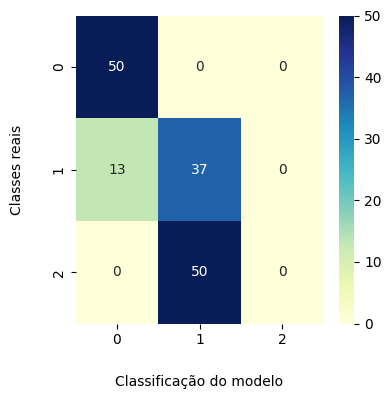

***********************
Épocas:  29
Update S [[0.35647395 0.87059397 0.10279478 0.65418181]
 [0.21132624 0.8893109  0.23700959 0.4685328 ]
 [0.3786915  1.         0.15034604 0.36655185]]
Update S [[0.21091792 0.61291729 0.07071498 0.65585326]
 [0.22421593 0.92824126 0.08181868 0.35208995]
 [0.24476924 1.         0.07285881 0.33619756]]
Update S [[0.28201453 0.75862019 0.06254151 0.35720377]
 [0.24969067 0.99481076 0.06191149 0.31078939]
 [0.25372652 1.         0.06080824 0.30977901]]
Update S [[0.28524246 0.91230707 0.05881918 0.31661682]
 [0.26038729 1.         0.0602137  0.30909579]
 [0.26237871 0.99744347 0.05991384 0.30907519]]
Update S [[0.27750151 0.96755085 0.05926128 0.3121765 ]
 [0.26596761 1.         0.06013627 0.31055979]
 [0.26697943 0.99804599 0.06001942 0.31059199]]
Update S [[0.27377977 0.98706168 0.05972735 0.31189168]
 [0.26862111 1.         0.06017102 0.3114549 ]
 [0.26910535 0.99897285 0.06012083 0.31147396]]
Update S [[0.27212021 0.99450791 0.05997959 0.31200158]
 [

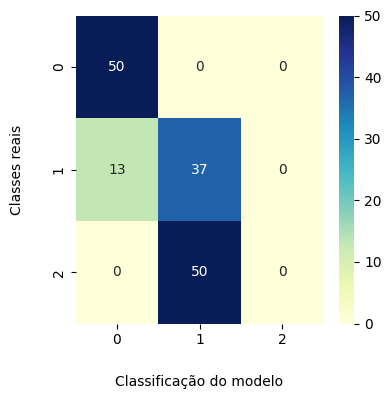

***********************
Épocas:  30
Update S [[0.09832111 0.16210326 0.15067767 1.        ]
 [0.15821071 0.12899883 0.12188207 0.96544142]
 [0.13264086 0.46076844 0.11090642 0.35429961]]
Update S [[0.20493708 0.49748971 0.10298984 0.56966085]
 [0.44527667 0.28848623 0.06538614 0.71215526]
 [0.26492585 1.         0.06665017 0.33875822]]
Update S [[0.2327666  0.89484531 0.07475955 0.32179395]
 [0.47118176 0.50679767 0.05676041 0.36969584]
 [0.26289997 1.         0.0609283  0.31282653]]
Update S [[0.24588284 1.         0.06246084 0.30728486]
 [0.37879652 0.70651284 0.0552879  0.31894889]
 [0.26279425 0.98565175 0.05937578 0.30685169]]
Update S [[0.25593524 1.         0.06030058 0.30663817]
 [0.31727568 0.85130784 0.0562723  0.31135778]
 [0.26473652 0.98401534 0.05921138 0.30680111]]
Update S [[0.26354935 1.         0.06010297 0.30921275]
 [0.29091829 0.93385821 0.05794729 0.31112163]
 [0.26778041 0.99122786 0.05965169 0.30934296]]
Update S [[0.26741585 1.         0.06013557 0.31075534]
 [

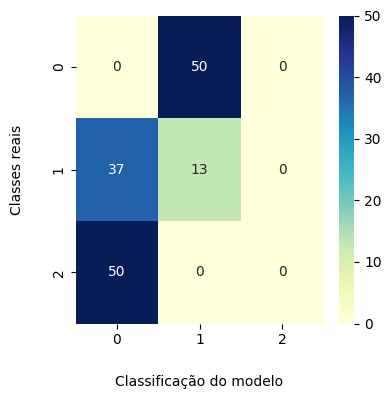

***********************
Épocas:  31
Update S [[0.27982986 0.76315327 0.14061699 0.24288825]
 [0.31534997 0.84019793 0.10125618 0.27186555]
 [0.17447978 0.19580977 0.21348662 1.        ]]
Update S [[0.21883178 1.         0.13776719 0.38959207]
 [0.29162516 0.97810543 0.17377589 0.23695515]
 [0.45912175 0.68565469 0.07835789 0.47615712]]
Update S [[0.15289671 1.         0.09172006 0.28912885]
 [0.13612139 0.60948269 0.15319534 0.31902196]
 [0.31056001 0.79916911 0.05454647 0.29950425]]
Update S [[0.17559553 1.         0.06088505 0.27459387]
 [0.15974049 0.80380525 0.06979238 0.32759793]
 [0.25286651 0.83747199 0.05118174 0.27085591]]
Update S [[0.226063   1.         0.05906825 0.29361582]
 [0.21377272 0.99335385 0.06159776 0.29973803]
 [0.26058894 0.92424317 0.05570876 0.29221149]]
Update S [[0.24893651 0.99250135 0.05923088 0.30095219]
 [0.243339   1.         0.06000631 0.30161763]
 [0.26456636 0.95875682 0.05769473 0.3009443 ]]
Update S [[0.26058225 0.99511789 0.05965675 0.30650553]
 [

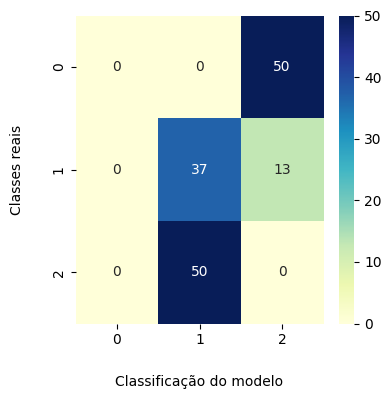

***********************
Épocas:  32
Update S [[0.206098   1.         0.1248099  0.9483393 ]
 [0.42866184 0.40718029 0.2787759  0.501337  ]
 [0.45352826 0.21787313 0.27913534 0.88443047]]
Update S [[0.20399574 1.         0.0859006  0.37878757]
 [0.25355273 0.7994955  0.09616914 0.34048108]
 [0.24982268 0.79106721 0.08849434 0.37953541]]
Update S [[0.23141284 1.         0.06214238 0.29855865]
 [0.24352783 0.95058907 0.06149396 0.30159983]
 [0.25192633 0.92712212 0.06004039 0.3061618 ]]
Update S [[0.25164225 1.         0.05978529 0.30356145]
 [0.25596049 0.98539573 0.05948331 0.30440078]
 [0.26075379 0.97297414 0.05898996 0.30515075]]
Update S [[0.26217267 1.         0.05996004 0.30838262]
 [0.26397601 0.99495127 0.05981081 0.3085981 ]
 [0.26625914 0.98943286 0.05959147 0.30879075]]
Update S [[0.26696126 1.         0.06010283 0.31055489]
 [0.26775564 0.99802215 0.0600314  0.31061633]
 [0.268807   0.99558299 0.05993104 0.31067888]]
Update S [[0.26905967 1.         0.0601639  0.31146989]
 [

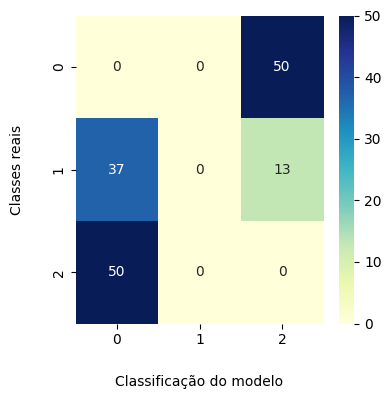

***********************
Épocas:  33
Update S [[0.3170766  0.72535224 0.10983388 0.40454165]
 [0.13837294 1.         0.11970707 0.61693829]
 [0.15984573 0.64219409 0.18398611 0.54107853]]
Update S [[0.33260951 0.87989861 0.06929684 0.38534028]
 [0.29748448 0.93085447 0.07203144 0.39179326]
 [0.27643015 1.         0.07582506 0.37284386]]
Update S [[0.29131371 0.93218659 0.06034824 0.32336202]
 [0.28281113 0.95192267 0.06095578 0.32292695]
 [0.26730235 1.         0.06220547 0.31870294]]
Update S [[0.27858706 0.97168289 0.05954388 0.31359735]
 [0.27519249 0.97966197 0.05983147 0.31336644]
 [0.26771957 1.         0.0604499  0.31233403]]
Update S [[0.27402674 0.98811426 0.05979352 0.31226088]
 [0.272521   0.99157024 0.05993087 0.31217475]
 [0.2691266  1.         0.06023119 0.31188447]]
Update S [[0.27219743 0.99482905 0.06000063 0.31212754]
 [0.27151334 0.99637836 0.06006486 0.31209328]
 [0.26997513 1.         0.06020674 0.31199778]]
Update S [[0.27139261 0.99769314 0.06011021 0.31213935]
 [

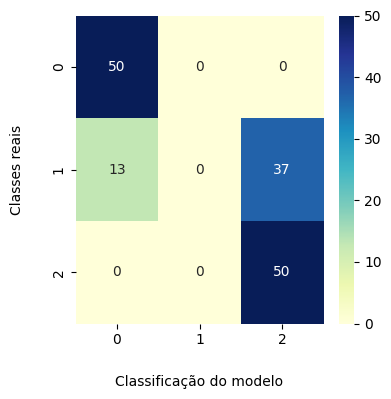

***********************
Épocas:  34
Update S [[0.32312793 0.2384467  0.16480743 0.35528362]
 [0.19582101 0.09199433 0.2504364  1.        ]
 [0.27193236 0.2768156  0.11031084 0.54331055]]
Update S [[0.25083605 0.35420972 0.13332145 0.61250423]
 [0.54467796 0.1166617  0.12057004 0.9470045 ]
 [0.26985803 1.         0.0738683  0.36397043]]
Update S [[0.284193   0.68815978 0.06913468 0.37144161]
 [0.5875626  0.29007014 0.06100358 0.48303289]
 [0.25841662 1.         0.06180328 0.31445404]]
Update S [[0.28191845 0.91158635 0.06021751 0.31958708]
 [0.47704969 0.52564322 0.05697981 0.34614466]
 [0.26407985 1.         0.06026251 0.31077845]]
Update S [[0.27517455 0.97374829 0.05980005 0.31303975]
 [0.36874685 0.74280373 0.05678238 0.3225077 ]
 [0.26770985 1.         0.06017646 0.31136162]]
Update S [[0.27254822 0.99105731 0.05996089 0.31220598]
 [0.31328108 0.88479139 0.05768752 0.31622376]
 [0.26941108 1.         0.06019187 0.31181581]]
Update S [[0.27151984 0.9965452  0.06008441 0.31213017]
 [

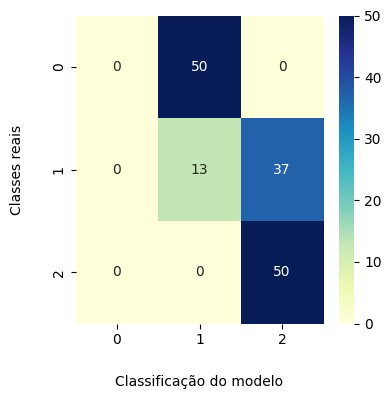

***********************
Épocas:  35
Update S [[0.28833185 0.79035848 0.18675111 0.36989311]
 [0.1993937  1.         0.1843405  0.42827622]
 [0.36935775 0.64313112 0.25553414 0.25933462]]
Update S [[0.20796239 0.98331942 0.09753546 0.33440929]
 [0.23380236 1.         0.07977462 0.35760751]
 [0.23504248 0.92149485 0.08551151 0.36012763]]
Update S [[0.26195874 0.95279124 0.06171208 0.32403217]
 [0.25703306 0.99616757 0.06148395 0.317034  ]
 [0.25305431 1.         0.06247199 0.31571111]]
Update S [[0.26955473 0.9757352  0.05951481 0.31199554]
 [0.26461445 0.99327978 0.0598508  0.31045402]
 [0.26165401 1.         0.060208   0.31000653]]
Update S [[0.27067193 0.98965606 0.05979035 0.31149865]
 [0.26825447 0.99644379 0.05998621 0.31114553]
 [0.26672551 1.         0.06014183 0.31100947]]
Update S [[0.27083584 0.99558719 0.06001385 0.31182786]
 [0.2697356  0.99834318 0.06011083 0.31173169]
 [0.2690136  1.         0.0601811  0.31168612]]
Update S [[0.27081805 0.99806759 0.06012047 0.31202095]
 [

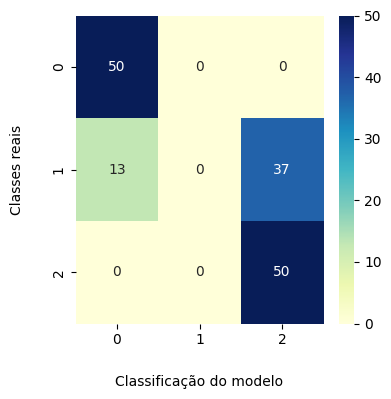

***********************
Épocas:  36
Update S [[0.11161148 0.38412681 0.06931904 0.25368047]
 [0.10528078 0.10956068 0.13499448 0.48417596]
 [0.12748139 0.03123308 0.1893483  1.        ]]
Update S [[0.18990637 1.         0.11272858 0.72387798]
 [0.47627763 0.88964891 0.07883127 0.46393976]
 [0.4805811  0.76772534 0.08309112 0.50548906]]
Update S [[0.1227946  1.         0.09148721 0.55192627]
 [0.33488363 0.95133878 0.05957647 0.3266757 ]
 [0.34739826 0.88455257 0.06053502 0.33332105]]
Update S [[0.13939782 1.         0.06523055 0.34932312]
 [0.24679475 0.88669024 0.05279327 0.27494633]
 [0.26057697 0.84997962 0.05203264 0.27562204]]
Update S [[0.2115638  1.         0.05979248 0.29947711]
 [0.25058708 0.93394918 0.05592052 0.28946661]
 [0.25902589 0.91532453 0.05519051 0.28951355]]
Update S [[0.24615559 1.         0.05973476 0.3024659 ]
 [0.26123529 0.96967669 0.05820339 0.30165195]
 [0.26545184 0.96065527 0.05780992 0.30168767]]
Update S [[0.25979869 1.         0.0599395  0.30722431]
 [

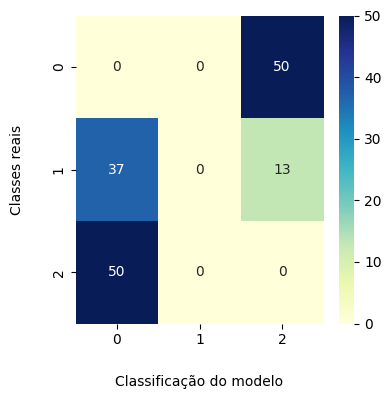

***********************
Épocas:  37
Update S [[0.22083669 0.65769438 0.11134739 0.44318293]
 [0.14110284 0.16757226 0.30312415 1.        ]
 [0.2455652  0.29401354 0.15608247 0.63601908]]
Update S [[0.23766927 1.         0.06131961 0.30298858]
 [0.31445301 0.20703442 0.1101138  0.61596874]
 [0.26257036 0.81803706 0.06330411 0.3247492 ]]
Update S [[0.25409363 1.         0.05896014 0.3015835 ]
 [0.44441052 0.45703563 0.05869724 0.37897258]
 [0.26453181 0.9472511  0.05893125 0.30596456]]
Update S [[0.2639611  1.         0.05973939 0.30817261]
 [0.38433253 0.70256804 0.05570489 0.32307687]
 [0.26803623 0.98462557 0.05956546 0.3091261 ]]
Update S [[0.26797907 1.         0.06005968 0.31070554]
 [0.32501023 0.85807407 0.05689607 0.31515835]
 [0.26965511 0.99496182 0.0599448  0.31093261]]
Update S [[0.26956423 1.         0.06015894 0.31159835]
 [0.29515862 0.93747597 0.05827377 0.31337828]
 [0.27028823 0.99811988 0.06009888 0.31166023]]
Update S [[0.2702095  1.         0.06019025 0.31193242]
 [

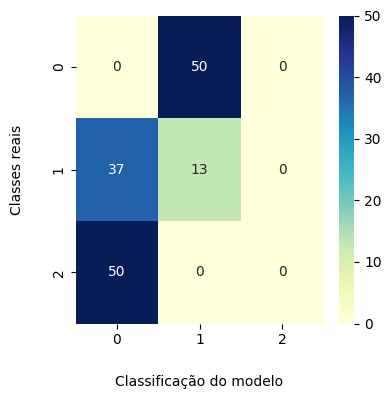

***********************
Épocas:  38
Update S [[0.07587553 0.12700777 0.21430987 0.72371917]
 [0.0705632  0.08299784 0.25521093 1.        ]
 [0.07778765 0.51655246 0.05479816 0.67881777]]
Update S [[0.37967514 0.2290571  0.08380378 0.64380098]
 [0.39773969 0.10260916 0.12309267 0.93401505]
 [0.23333301 1.         0.06264203 0.32101781]]
Update S [[0.46792218 0.46601156 0.05741428 0.37183517]
 [0.53362672 0.30311041 0.06140035 0.46873938]
 [0.2540159  1.         0.05975058 0.30671688]]
Update S [[0.39169373 0.68896417 0.0559638  0.32470327]
 [0.45307199 0.55362337 0.05696037 0.34322803]
 [0.26394306 1.         0.05997531 0.30978071]]
Update S [[0.32727304 0.84874089 0.0569984  0.31683946]
 [0.35851814 0.76644856 0.05681997 0.32128627]
 [0.26796193 1.         0.06013774 0.31129139]]
Update S [[0.29573797 0.9343416  0.05830882 0.31402304]
 [0.30910443 0.89683491 0.05781344 0.31569085]
 [0.2695717  1.         0.06018731 0.3118382 ]]
Update S [[0.28189485 0.9719076  0.05922938 0.31281943]
 [

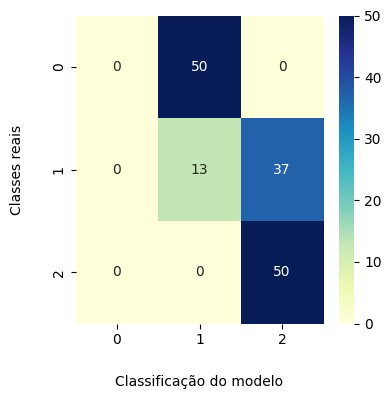

***********************
Épocas:  39
Update S [[0.20494829 0.13005602 0.18106644 0.69676186]
 [0.16432351 0.14703445 0.20379074 0.68295773]
 [0.08137851 0.20117242 0.20540874 1.        ]]
Update S [[0.5594189  1.         0.08609913 0.51307803]
 [0.56476837 0.97434891 0.08671679 0.51788252]
 [0.54103993 0.85277461 0.09379909 0.57102766]]
Update S [[0.38567298 1.         0.06496371 0.35867782]
 [0.38802226 0.9887985  0.0651152  0.35970605]
 [0.39508803 0.92885425 0.06630834 0.36930478]]
Update S [[0.29866636 1.         0.0601522  0.3168949 ]
 [0.30007402 0.99548601 0.06011314 0.31704441]
 [0.30850722 0.96766655 0.05986435 0.31856182]]
Update S [[0.27610666 1.         0.05992063 0.31134211]
 [0.27699753 0.99792598 0.05985066 0.31134932]
 [0.28262027 0.98463723 0.05942533 0.311487  ]]
Update S [[0.27183128 1.         0.06006571 0.31136201]
 [0.27228664 0.99901336 0.06002373 0.31136586]
 [0.27519993 0.99264822 0.05976181 0.31140404]]
Update S [[0.27098394 1.         0.06014715 0.31173619]
 [

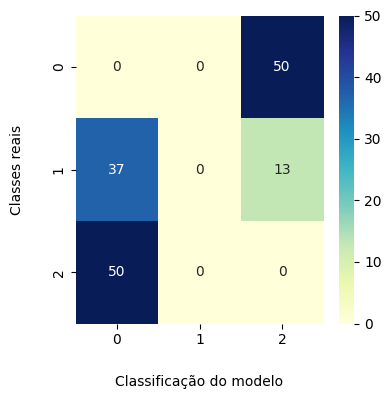

***********************
Épocas:  40
Update S [[0.0781531  0.63450229 0.27871146 0.53214239]
 [0.36310528 0.25555036 0.27703207 0.28610336]
 [0.21337188 1.         0.18313257 0.18821719]]
Update S [[0.18042553 0.70951053 0.10007542 0.42874104]
 [0.4599419  0.35379301 0.07808716 0.43226239]
 [0.24115323 1.         0.06941424 0.32812376]]
Update S [[0.25851327 0.91662293 0.06263822 0.32301813]
 [0.45477935 0.56035083 0.0556637  0.33799252]
 [0.25593918 1.         0.06050694 0.30959784]]
Update S [[0.26683936 0.9800681  0.06029123 0.31239172]
 [0.372977   0.74564561 0.05561877 0.31843727]
 [0.26424499 1.         0.06008531 0.3102307 ]]
Update S [[0.26895566 0.99501166 0.06015855 0.3117619 ]
 [0.31776698 0.87671594 0.05711777 0.3154208 ]
 [0.26798155 1.         0.06015477 0.3113539 ]]
Update S [[0.26992561 0.99861247 0.06017523 0.31193061]
 [0.29170082 0.94583113 0.0584947  0.31350833]
 [0.26955967 1.         0.06018997 0.31184431]]
Update S [[0.27036575 0.99955315 0.06019187 0.312058  ]
 [

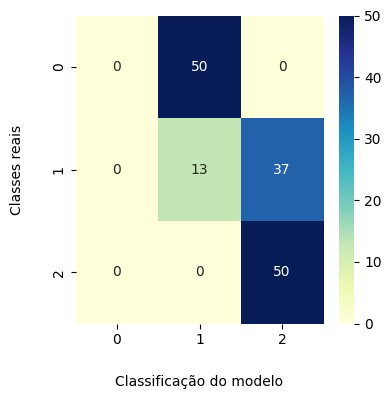

***********************
Épocas:  41
Update S [[0.26499951 0.62182135 0.11624868 0.28667216]
 [0.24000309 0.11286755 0.20498692 0.98894511]
 [0.10162184 0.68247039 0.07917962 1.        ]]
Update S [[0.20622085 0.74730778 0.11101276 0.33567337]
 [0.52245435 0.16697154 0.07705955 0.85428852]
 [0.22378072 1.         0.07261374 0.35341126]]
Update S [[0.27064373 0.8548189  0.06114234 0.33024658]
 [0.5497829  0.36250347 0.05690301 0.41192088]
 [0.2498074  1.         0.06057575 0.30870832]]
Update S [[0.27743865 0.9476923  0.05896615 0.31350707]
 [0.43685143 0.59121891 0.05635902 0.33391725]
 [0.26199256 1.         0.05997464 0.30933411]]
Update S [[0.27439536 0.98017043 0.0595288  0.311967  ]
 [0.34778051 0.78990738 0.05685998 0.31976143]
 [0.26711925 1.         0.06011866 0.31102816]]
Update S [[0.27250794 0.99190405 0.05988869 0.3119938 ]
 [0.30414576 0.90879272 0.05797267 0.31518803]
 [0.26921895 1.         0.06018015 0.31173152]]
Update S [[0.2715691  0.99651368 0.0600613  0.31208442]
 [

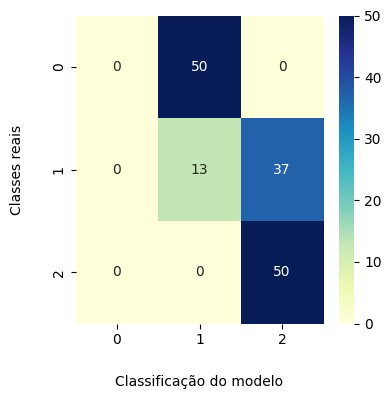

***********************
Épocas:  42
Update S [[0.09778164 0.2238976  0.1982046  1.        ]
 [0.20462232 0.57066389 0.13950357 0.26638009]
 [0.15381795 0.20329691 0.18018559 0.77012747]]
Update S [[0.38171193 0.52198868 0.10706091 0.6189672 ]
 [0.26009788 1.         0.24178599 0.20995559]
 [0.45066359 0.82871501 0.07734501 0.45709386]]
Update S [[0.39306629 0.79395461 0.06748669 0.38421856]
 [0.10651037 1.         0.23519688 0.32302376]
 [0.36037305 0.9854804  0.06466905 0.35233935]]
Update S [[0.24056063 0.67234793 0.04402038 0.23918021]
 [0.03063319 0.37316885 0.14897041 1.        ]
 [0.22153112 0.73265283 0.0445677  0.2354206 ]]
Update S [[0.29183943 0.97226396 0.05964133 0.31778194]
 [0.07789182 0.92674285 0.12400947 0.60075685]
 [0.28128131 1.         0.06030886 0.3170171 ]]
Update S [[0.27071085 0.95245896 0.0576349  0.30229754]
 [0.18021718 1.         0.07087385 0.35171418]
 [0.26559455 0.96429103 0.05806095 0.30210689]]
Update S [[0.26412946 0.95375017 0.05750483 0.30014253]
 [

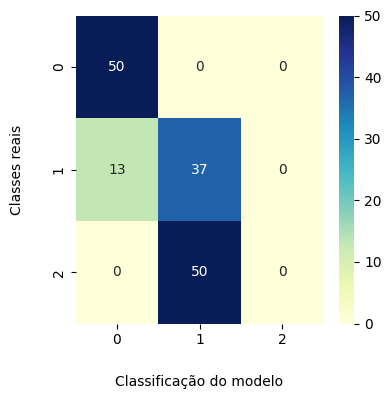

***********************
Épocas:  43
Update S [[0.27264777 0.3899738  0.12060052 0.68078275]
 [0.17119095 0.18270761 0.27909861 1.        ]
 [0.18468003 0.68957971 0.15335455 0.44698612]]
Update S [[0.4508393  0.4570506  0.07565759 0.44140739]
 [0.39387865 0.24618551 0.10032724 0.70735   ]
 [0.27166853 1.         0.07137227 0.3549027 ]]
Update S [[0.35565304 0.69391238 0.06069692 0.3450049 ]
 [0.48232402 0.45699167 0.05894114 0.39779317]
 [0.26579585 1.         0.06155319 0.31588158]]
Update S [[0.30429268 0.88122225 0.05875003 0.31960092]
 [0.40581891 0.67733184 0.05591797 0.32757289]
 [0.26748332 1.         0.06034844 0.31191078]]
Update S [[0.28450887 0.95642991 0.05917774 0.31380721]
 [0.33535272 0.83711592 0.05678592 0.31698751]
 [0.26912466 1.         0.06021481 0.31182678]]
Update S [[0.27668969 0.98297089 0.05965685 0.31255832]
 [0.29957411 0.92710084 0.05811064 0.31422306]
 [0.26999366 1.         0.06020414 0.31199315]]
Update S [[0.27338254 0.9928718  0.05993856 0.3122764 ]
 [

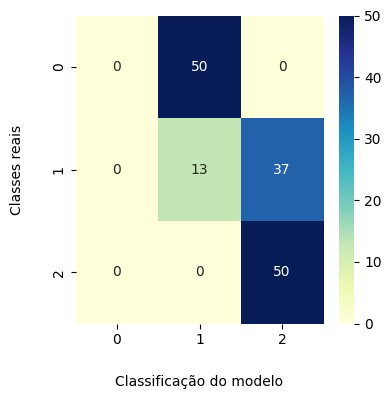

***********************
Épocas:  44
Update S [[0.20821661 0.76521891 0.17398379 0.34442308]
 [0.38719922 0.74760376 0.13059754 0.25255802]
 [0.20914849 0.17508345 0.26073675 1.        ]]
Update S [[0.15385384 1.         0.29151964 0.51214481]
 [0.30993839 0.87454427 0.2412059  0.35133697]
 [0.55684968 0.72578381 0.09656648 0.58856886]]
Update S [[0.1961455  0.75184138 0.26121567 0.25336525]
 [0.27519867 1.         0.22406498 0.15828164]
 [0.41188923 0.91270628 0.06806156 0.38144985]]
Update S [[0.1930746  1.         0.17478104 0.15987559]
 [0.10268066 0.78341684 0.19610457 0.34200491]
 [0.30797342 0.944314   0.05895984 0.31464127]]
Update S [[0.23523006 0.87415398 0.08099592 0.33230881]
 [0.17914665 0.83438141 0.08582852 0.43140065]
 [0.288749   1.         0.06043511 0.3171582 ]]
Update S [[0.2294123  1.         0.06315063 0.30173677]
 [0.21693411 0.99788208 0.06440266 0.31355361]
 [0.26538735 0.95532673 0.05752552 0.29972984]]
Update S [[0.24505939 0.99773154 0.06012522 0.30151215]
 [

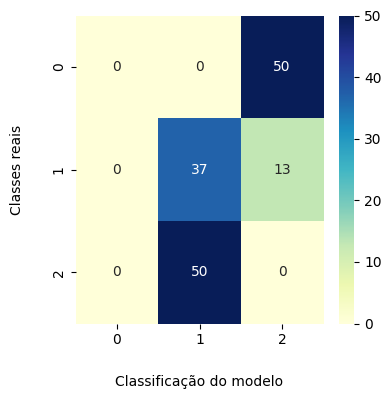

***********************
Épocas:  45
Update S [[0.55999666 0.77908297 0.22458994 0.7646093 ]
 [0.57958072 0.77396632 0.22004493 0.7590173 ]
 [0.57028566 1.         0.35668568 0.36831627]]
Update S [[0.30377299 0.31566956 0.10993605 1.        ]
 [0.47512313 0.3024652  0.09330538 0.78620124]
 [0.25328576 0.91253858 0.11258062 0.40513181]]
Update S [[0.24138941 0.46110191 0.09506308 0.52999502]
 [0.32549397 0.38338299 0.08533302 0.5266304 ]
 [0.25629105 1.         0.06644341 0.32931645]]
Update S [[0.28686677 0.81219478 0.0627099  0.33810669]
 [0.30612951 0.7439918  0.06282416 0.34524729]
 [0.26127733 1.         0.06068293 0.3115746 ]]
Update S [[0.27867028 0.94716515 0.0598655  0.31542409]
 [0.28564154 0.92293495 0.05961957 0.31710749]
 [0.26619498 1.         0.06019261 0.31106043]]
Update S [[0.27387335 0.98348875 0.05987106 0.31253221]
 [0.27668743 0.97521001 0.05968905 0.31293107]
 [0.26872231 1.         0.06018485 0.31163052]]
Update S [[0.27205056 0.99407309 0.06002408 0.31216492]
 [

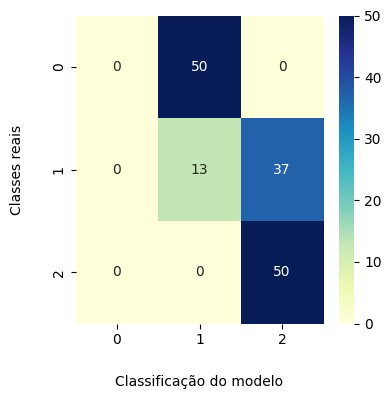

***********************
Épocas:  46
Update S [[0.51756355 0.28492236 0.31413    0.36503068]
 [0.29300593 1.         0.13433638 0.42959472]
 [0.33428631 0.82427071 0.12666336 0.48449526]]
Update S [[0.50073055 0.33670029 0.08432928 0.50922821]
 [0.24123955 0.9791073  0.09855634 0.31101051]
 [0.29710693 1.         0.06919198 0.35218423]]
Update S [[0.4561799  0.52855464 0.0551381  0.34035821]
 [0.23134684 1.         0.06537159 0.29919991]
 [0.26281782 0.95760508 0.05902405 0.30460976]]
Update S [[0.3621272  0.727283   0.05428075 0.31054388]
 [0.24457334 1.         0.06028989 0.30107849]
 [0.26160599 0.96451595 0.05823611 0.30212308]]
Update S [[0.31183594 0.86975876 0.05639724 0.31018929]
 [0.25801877 1.         0.0599781  0.3065954 ]
 [0.26616853 0.98217227 0.05912906 0.30694765]]
Update S [[0.28908745 0.942326   0.05813088 0.31104957]
 [0.26490112 1.         0.06006623 0.3095656 ]
 [0.26868138 0.99164876 0.05969053 0.30971769]]
Update S [[0.27901558 0.97458213 0.05917673 0.31156031]
 [

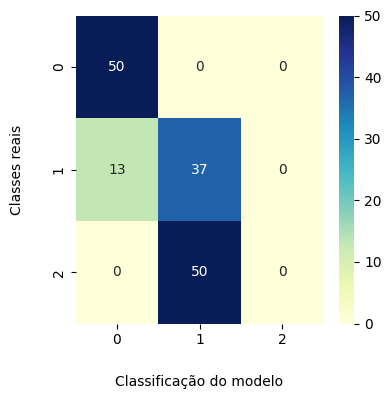

***********************
Épocas:  47
Update S [[0.24192796 0.70047783 0.09368266 0.26995559]
 [0.18043415 0.12772443 0.18596847 1.        ]
 [0.08322028 0.80326749 0.14940447 0.42912027]]
Update S [[0.23812753 0.96588152 0.067341   0.30759308]
 [0.44806151 0.20079349 0.06909625 0.76638657]
 [0.21918422 1.         0.06732934 0.32283154]]
Update S [[0.26176825 0.96201976 0.05843855 0.30882682]
 [0.50195558 0.41437539 0.05649494 0.38676452]
 [0.24955206 1.         0.05966431 0.30523876]]
Update S [[0.26933311 0.98167048 0.05921226 0.31012114]
 [0.40956946 0.64312432 0.05612914 0.32838819]
 [0.2623621  1.         0.05987536 0.30906455]]
Update S [[0.27073029 0.99185579 0.05979429 0.31135752]
 [0.33513616 0.8235539  0.05693643 0.31812725]
 [0.26737386 1.         0.06010976 0.31105733]]
Update S [[0.27089416 0.99638775 0.06003361 0.31185892]
 [0.29891275 0.92403845 0.05817392 0.31449796]
 [0.2693431  1.         0.06018018 0.31176066]]
Update S [[0.27084475 0.99837978 0.06013195 0.31204744]
 [

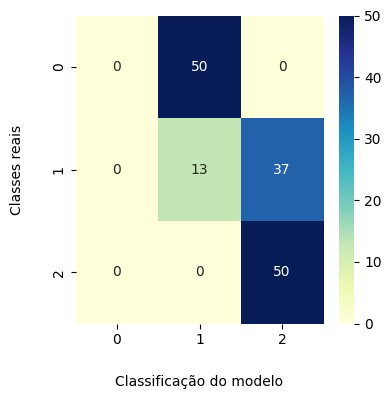

***********************
Épocas:  48
Update S [[0.08650309 0.0445477  0.33304742 1.        ]
 [0.08663505 0.1164937  0.18804072 0.67626203]
 [0.0642601  0.10655997 0.19316655 0.97027668]]
Update S [[0.50645504 0.52685365 0.11408152 0.68325115]
 [0.51415046 1.         0.08241751 0.49081391]
 [0.50849468 0.84958523 0.08903864 0.54069791]]
Update S [[0.40211825 0.77645204 0.06747425 0.38367329]
 [0.36651924 1.         0.06337988 0.34795241]
 [0.37688442 0.93058767 0.06451228 0.35724009]]
Update S [[0.31953394 0.90842442 0.05938981 0.32057966]
 [0.2934756  1.         0.05985271 0.31462837]
 [0.30298029 0.96907938 0.05954103 0.31612847]]
Update S [[0.29028866 0.96119019 0.05890696 0.31201248]
 [0.27524564 1.         0.05988883 0.31110837]
 [0.28127074 0.98566105 0.05942829 0.31126662]]
Update S [[0.27926712 0.98269447 0.05943712 0.31162701]
 [0.27175183 1.         0.06006761 0.31139979]
 [0.27481481 0.99324863 0.05979213 0.31145048]]
Update S [[0.27451517 0.99212345 0.05983065 0.31189085]
 [

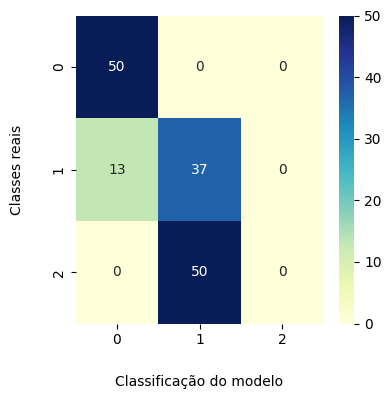

***********************
Épocas:  49
Update S [[0.08871958 0.04892535 0.5947354  1.        ]
 [0.30612961 0.17074673 0.13763198 0.35883937]
 [0.12218827 0.12928923 0.19425218 0.84123898]]
Update S [[0.28065006 0.2092846  0.3777618  1.        ]
 [0.5718279  0.89069472 0.08636629 0.50440801]
 [0.52123426 0.883276   0.08966908 0.53746274]]
Update S [[0.38735875 0.29395227 0.13078617 0.64661346]
 [0.39410274 1.         0.0662535  0.36878944]
 [0.39401971 0.97451857 0.06733581 0.37242826]]
Update S [[0.42422495 0.51773405 0.06317798 0.38818704]
 [0.28442404 1.         0.0602056  0.31456218]
 [0.30224185 0.96103942 0.05908927 0.31383779]]
Update S [[0.35442366 0.7596959  0.0565857  0.32012987]
 [0.2643902  1.         0.05994749 0.30773654]
 [0.27793899 0.97290702 0.05867702 0.30740189]]
Update S [[0.30936055 0.89219243 0.0572644  0.3119551 ]
 [0.26573488 1.         0.06001448 0.30916881]
 [0.27281527 0.98547996 0.05932286 0.30914467]]
Update S [[0.28834204 0.9523427  0.05849587 0.3115613 ]
 [

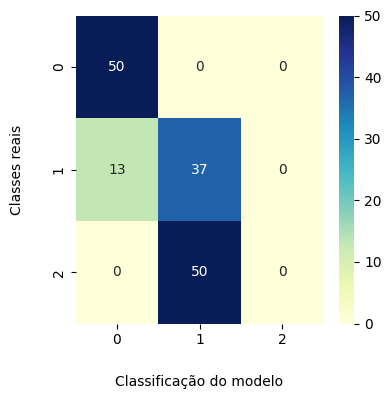

In [ ]:
for num_epocas in range(50):
  print("***********************")
  print("Épocas: ", num_epocas)
  if __name__ == '__main__':
    algo = KFCM_K_W2(X)
    s, g, U, J_custo = algo.fit()

    print("Função de custo: ", J_custo)
    print("----------------")
    print("Parâmetros de Largura s: ", s)
    print("----------------")
    print("Protótipos de cada grupo g:", g)
    print("----------------")
    print("Matriz U: ", U)

    # Partição Crisp
    x = np.array(range(0, 150))
    pred_label=[]
    for i in range(150):
      indice_max = np.argmax(U[:,i])
      pred_label.append(indice_max)

   # plt.scatter(x, y, marker='x')
    #plt.title("U Crisp elements")
    #plt.xlabel("Amostras")
    #plt.ylabel("Classes")
    #plt.show()
    print("U Crisp:",pred_label)

    ##ARI considerando a partição CRISP
    print("Predict labels:",pred_label)
    print("True labels:",np.transpose(label))
    respred_label= np.reshape(pred_label, (150,1)).ravel()
    ari=ARI(label.ravel(),respred_label)
    print("ARI:",ari)

    #Calcular partition coefficient
    cluster=3
    partition_coefficient = 0
    for i in range(cluster):
      for j in range(len(X)):
        partition_coefficient += U[i,j]**2
    partition_coefficient /= len(X)
    print("Fuzzy Partition Coefficient:", partition_coefficient)

    #Modified partition Coefficient
    MPC = 1 - (cluster/cluster-1)*(1 - partition_coefficient)
    print("Modified partition Coefficient:", MPC)

    #Matriz confusão
    conf_matrix = confusion_matrix(label.ravel(), pred_label)
    # Plotar a matriz de confusão
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cbar=True,
        cmap='YlGnBu'
    )
    ax.set_xlabel("Classificação do modelo", labelpad=20)
    ax.set_ylabel("Classes reais", labelpad=20)
    plt.show()

    # incrementa o número de épocas
    num_epocas += 1

In [ ]:
print(Decimal('1'))

In [ ]:
'''#eq.14b
    def compute_widths(self):
        # Loop through clusters (i) from 1 to the total number of clusters
        for i in range(self.c):

            # Initialize an empty list to store the sum of values for each feature (h)
            value_sumnum = []

            # Loop through the features (h) in the data frame (df)
            for h in range(self.p):

                # Initialize an empty list to store the numerator values
                value_of_k = []

                # Calculate the numerator values for each data point (k) in the cluster
                value_of_k = ((self.U[i] ** self.m) * self.gaussian_kernel(self.data, self.g[i], self.s[i]) * (self.data[:, h] - self.g[i, h]) ** 2)*(1e10)
                #print("U[i]", self.U[i])
                #print("g[i]",self.g[i])
                #print("s[i]",self.s[i])
                #print("g[i, h]", self.g[i, h])
                #print("data[:, h]", self.data[:, h])

                # Store the sum of the numerator values for this feature
                value_sumnum.append(np.sum(value_of_k))
            print("Kernel Value", value_of_k)
            print("Cluster", i)
            print("Valor da soma", value_sumnum)

            # Calculate the denominator product for the cluster
            product_num = (np.prod(value_sumnum))**(1/self.p) +0.01
            print("Valor do produto", product_num)

            # Loop through the features (j) in the data frame (df) again
            for j in range(self.p):

                # Initialize an empty list to store the numerator values
                value_k_den = []

                # Calculate the numerator values for each data point (k) in the cluster
                value_k_den = ((self.U[i] ** self.m) * self.gaussian_kernel(self.data, self.g[i], self.s[i]) * (self.data[:, j] - self.g[i, j]) ** 2)*(1e20)

                # Value Denominador
                value_sumden = (np.sum(value_k_den))
                print("value_k_den", value_k_den)
                print("value_sumden", value_sumden)

                # Calculate and store the updated width value for this feature
                self.s[i, j] = (product_num / value_sumden)
        print("Matris de Janela", self.s)
        return self.s'''

In [ ]:
'''    def compute_widths(self):
        produtorios = []
        for i in range(self.c):
            kernel_values = self.gaussian_kernel(self.data, self.g[i], self.s[i])
            U_powered = self.U[i] ** self.m
            diffs = self.data - self.g[i]
            diffs_squared = diffs ** 2
            numerator = (U_powered * kernel_values)[:, None] * diffs_squared
            denominator = U_powered * kernel_values
            # Denominador
            epsilon = 1e-10
            denominator[denominator == 0] = epsilon
            # Numerador
            s_i = np.sum(numerator, axis=0)
            # Armazena o resultado do produtório
            produtorio = np.prod(produtorios) * s_i if produtorios else s_i
            produtorios.append(s_i)  # Adiciona o valor atual do numerador à lista de produtórios
            # Atualiza a largura s
            s_updated = produtorio**(1/self.p) / np.sum(denominator)
            print(s_updated)
            # Verifica valores inválidos e trate-os
            if np.isnan(s_updated).any() or np.isinf(s_updated).any():
                s_updated[np.isnan(s_updated) | np.isinf(s_updated)] = 1.1
            self.s[i] = s_updated
        # Normaliza as linhas de self.s para que o produtório seja 1.0
        self.s = self.s / np.prod(self.s, axis=0, keepdims=True)
        print("Produto dos elementos da linha 0 da matriz 1/sij²", np.prod(self.s[0,:]))
        print("Produto dos elementos da linha 1 da matriz 1/sij²", np.prod(self.s[1,:]))
        print("Produto dos elementos da linha 2 da matriz 1/sij²", np.prod(self.s[2,:]))
        return self.s
'''

In [ ]:
'''print("----------------")
  print("Função de Custo")
  print(J_custo)
  print("----------------")
  print(U)
  print("Itens da Matriz U ", len(U))
  print(U.shape)
  for iter1 in range(3):
      plt.scatter(X[np.argmax(U, axis=0) == iter1, 0], X[np.argmax(U, axis=0) == iter1, 1], marker='x')
  plt.show()

  import numpy as np
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import figure

  figure(figsize=(8, 6))
  x = np.array(range(0, 150))
  y = np.argmax(U, axis=0)
  plt.title("U elements")
  plt.xlabel("Amostras")
  plt.ylabel("Classes")
  plt.scatter(x, y, marker='x')
  plt.show()'''

In [ ]:
  '''print("----------------")
  print(g)
  print("Itens da Matriz G ", len(g))
  print(g.shape)
  figure(figsize=(8, 6))
  x = np.array(range(0, 4))
  y = np.argmax(g, axis=0)
  plt.title("G elements")
  plt.xlabel("Features")
  plt.ylabel("Classes")
  plt.scatter(x, y, marker='x')
  plt.show()'''

In [ ]:
  cluster=3
  lcut= 0.20
  Ucrisp = fuzz.lambda_cut(U, lcut)
  figure(figsize=(8, 6))
  x = np.array(range(0, 150))
  y = np.argmax(Ucrisp, axis=0)

  plt.scatter(x, y, marker='x')
  plt.title("U Crisp elements")
  plt.xlabel("Amostras")
  plt.ylabel("Classes")
  plt.show()
  #Ucrisp1 = fuzz.centroid(g,U)
  #print(Ucrisp.shape)
  print("U Crisp:",Ucrisp)

##ARI considerando a partição CRISP
print("Predict labels:",y)
print("True labels:",np.transpose(label))
pred_label= np.reshape(y, (150,1)).ravel()
ari=ARI(label.ravel(),pred_label)
print("ARI:",ari)


In [ ]:
#Matriz confusão
conf_matrix = confusion_matrix(label.ravel(), pred_label)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cbar=True,
    cmap='YlGnBu'
)

ax.set_xlabel("Classificação do modelo", labelpad=20)
ax.set_ylabel("Classes reais", labelpad=20)

plt.show()

In [ ]:
#Calcular partition coefficient
partition_coefficient = 0
for i in range(cluster):
  for j in range(len(X)):
    partition_coefficient += U[i,j]**2

partition_coefficient /= len(X)

print("Fuzzy Partition Coefficient:", partition_coefficient)

#Modified partition Coefficient
MPC = 1 - (cluster/cluster-1)*(1 - partition_coefficient)
print("Modified partition Coefficient:", MPC)


In [ ]:
teste = np.array([[1, 5, 0],
                  [1, 3, 0],
                  [0, 0, 2]])

soma0 = np.sum(teste, axis=0)
print("Axis 0", soma0)

soma1 = np.sum(teste, axis=1)
soma1
print("Axis 1", soma1)